# Iyzico Member Businesses' Expected Transaction Volume Estimation Study

Iyzico that makes the online shopping experience easier for both buyers and sellers is a financial technology company. Iyzico provides payment infrastructure for E-commerce companies, marketplaces, and individual users. It is expected that the total transaction volume will be estimated on a merchant_id and daily basis for the last 3 months of 2020.

## Variables:

* **transaction_date**: Date of sales data
* **merchant_id**: IDs of member businesses (unique number for each member business)
* **Total_Transaction**: Number of transactions
* **Total_Paid**: Payment amount

In [25]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f'% x)
warnings.filterwarnings("ignore")

## 1. Loading The Data

In [28]:
df = pd.read_csv("iyzico_data.csv", parse_dates=["transaction_date"])
df.head()

Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
0           0       2018-01-01          535                349   25883.226
1           1       2018-01-01        42616                141   40918.860
2           2       2018-01-01        46774                410  306902.700
3           3       2018-01-01        86302                 10      11.340
4           4       2018-01-01       124381                285  111383.766

In [30]:
df.tail()

Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
7662        7662       2020-12-31        46774               3394 3174751.332
7663        7663       2020-12-31        57192                856  337696.020
7664        7664       2020-12-31        86302               2657   10461.006
7665        7665       2020-12-31       124381               3668 2445655.950
7666        7666       2020-12-31       129316                485    2101.050

In [32]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid
0       2018-01-01          535                349   25883.226
1       2018-01-01        42616                141   40918.860
2       2018-01-01        46774                410  306902.700
3       2018-01-01        86302                 10      11.340
4       2018-01-01       124381                285  111383.766

In [34]:
df["transaction_date"].dtypes

dtype('<M8[ns]')

## 2. Exploratory Data Analysis

In [37]:
## check function:

def check_df(dataframe, head=5):
    print("############ Shape ############")
    print(dataframe.shape)
    print("############ Types ############")
    print(dataframe.dtypes)
    print("############ Head ############")
    print(dataframe.head(head))
    print("############ Tail ############")
    print(dataframe.tail(head))
    print("############ NA ############")
    print(dataframe.isnull().sum())
    print("############ Quantiles ############")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [39]:
# max and min date in data set:

df["transaction_date"].min(), df["transaction_date"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [41]:
check_df(df)

############ Shape ############
(7667, 4)
############ Types ############
transaction_date     datetime64[ns]
merchant_id                   int64
Total_Transaction             int64
Total_Paid                  float64
dtype: object
############ Head ############
  transaction_date  merchant_id  Total_Transaction  Total_Paid
0       2018-01-01          535                349   25883.226
1       2018-01-01        42616                141   40918.860
2       2018-01-01        46774                410  306902.700
3       2018-01-01        86302                 10      11.340
4       2018-01-01       124381                285  111383.766
############ Tail ############
     transaction_date  merchant_id  Total_Transaction  Total_Paid
7662       2020-12-31        46774               3394 3174751.332
7663       2020-12-31        57192                856  337696.020
7664       2020-12-31        86302               2657   10461.006
7665       2020-12-31       124381               3668 2445655.95

In [43]:
# number of unique workplaces

df["merchant_id"].nunique()

7

In [45]:
df['merchant_id'].unique()

array([   535,  42616,  46774,  86302, 124381, 129316,  57192],
      dtype=int64)

In [47]:
# Total transaction volume by workplace:

df.groupby("merchant_id").agg({"Total_Transaction": "sum"}).sort_values(by="Total_Transaction", ascending=False)

Total_Transaction
merchant_id                   
124381                 1935357
46774                  1599559
535                    1302725
57192                  1146440
42616                  1126191
86302                   840951
129316                  440029

In [49]:
# Total paid volume by workplace:
df.groupby("merchant_id").agg({"Total_Paid": "sum"}).sort_values(by="Total_Paid", ascending=False)

Total_Paid
merchant_id               
46774       1567200341.286
124381      1158692543.973
42616        354583091.808
57192        317337137.586
535          156601530.234
86302          2870446.716
129316         1555471.476

In [51]:
# Transaction volume statistics of member businesses:
df.groupby("merchant_id").agg({"Total_Transaction": ["sum","mean","median","std"]})

Total_Transaction                           
                          sum     mean   median      std
merchant_id                                             
535                   1302725 1188.618 1029.500  498.633
42616                 1126191 1027.547  667.000 1780.256
46774                 1599559 1459.452 1313.500  844.590
57192                 1146440 1050.816 1073.000  215.101
86302                  840951  767.291  160.000 1127.962
124381                1935357 1765.837  816.500 2245.710
129316                 440029  401.486  383.000  210.783

Let's visualize the transaction volume numbers on a yearly basis:

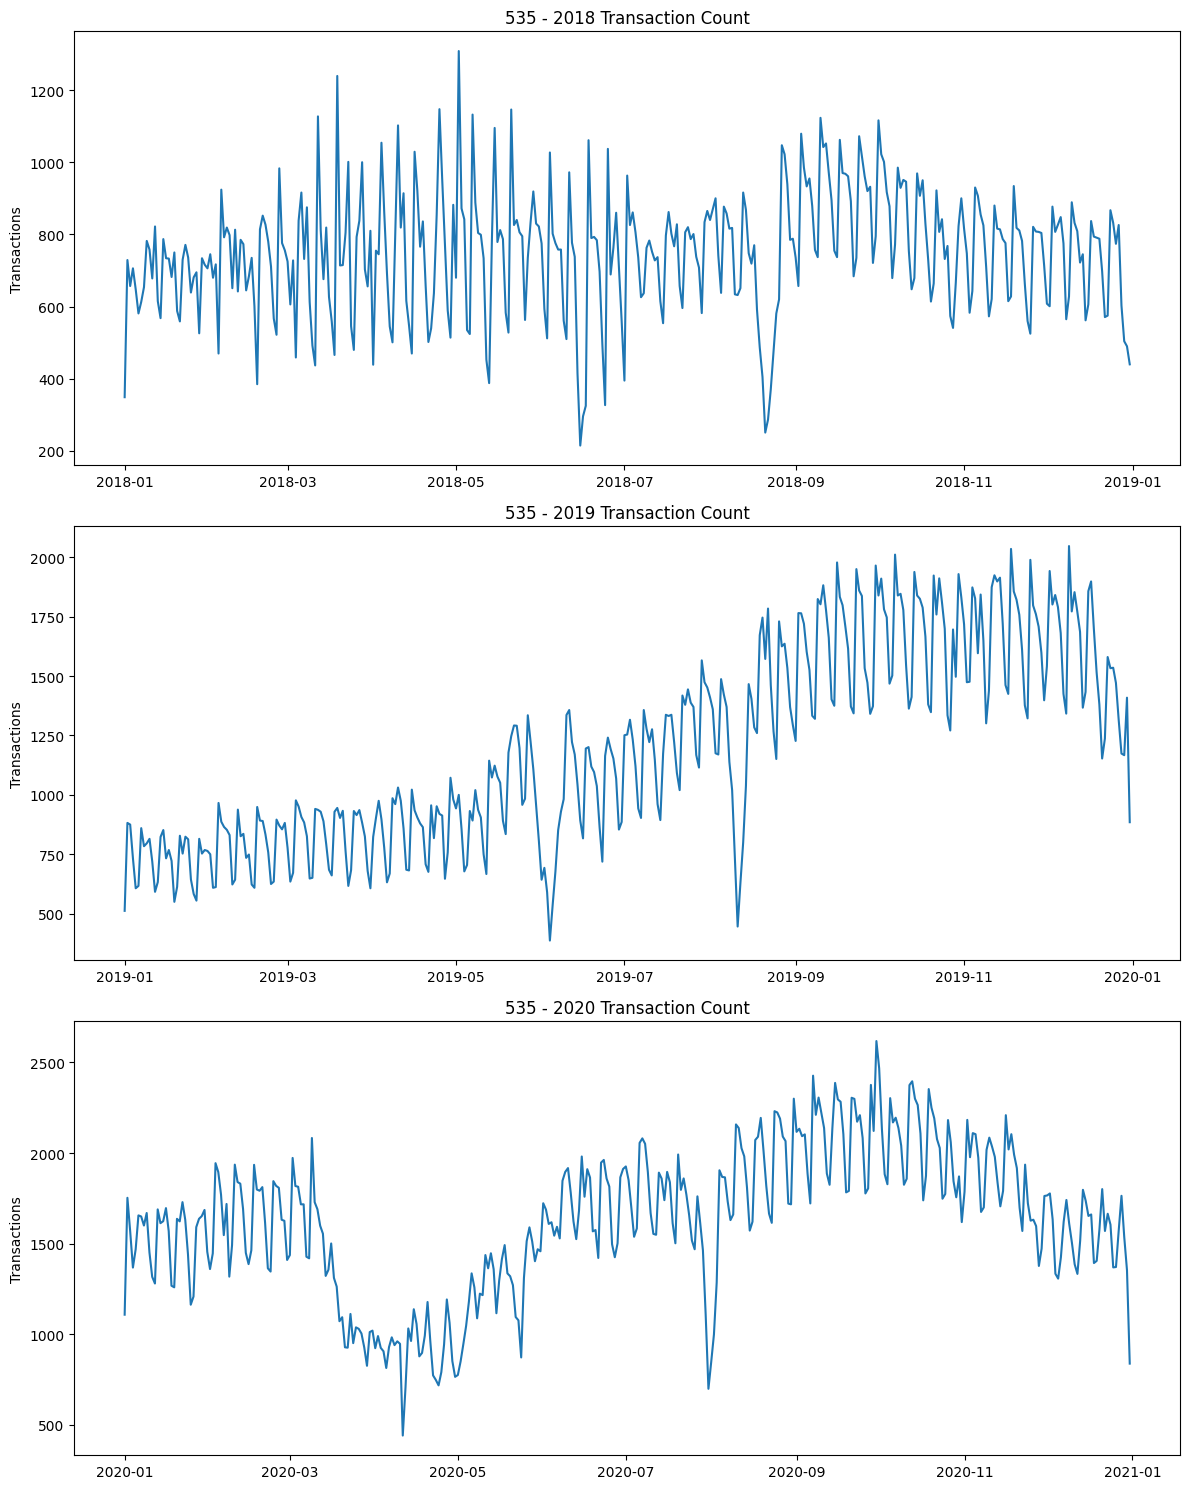

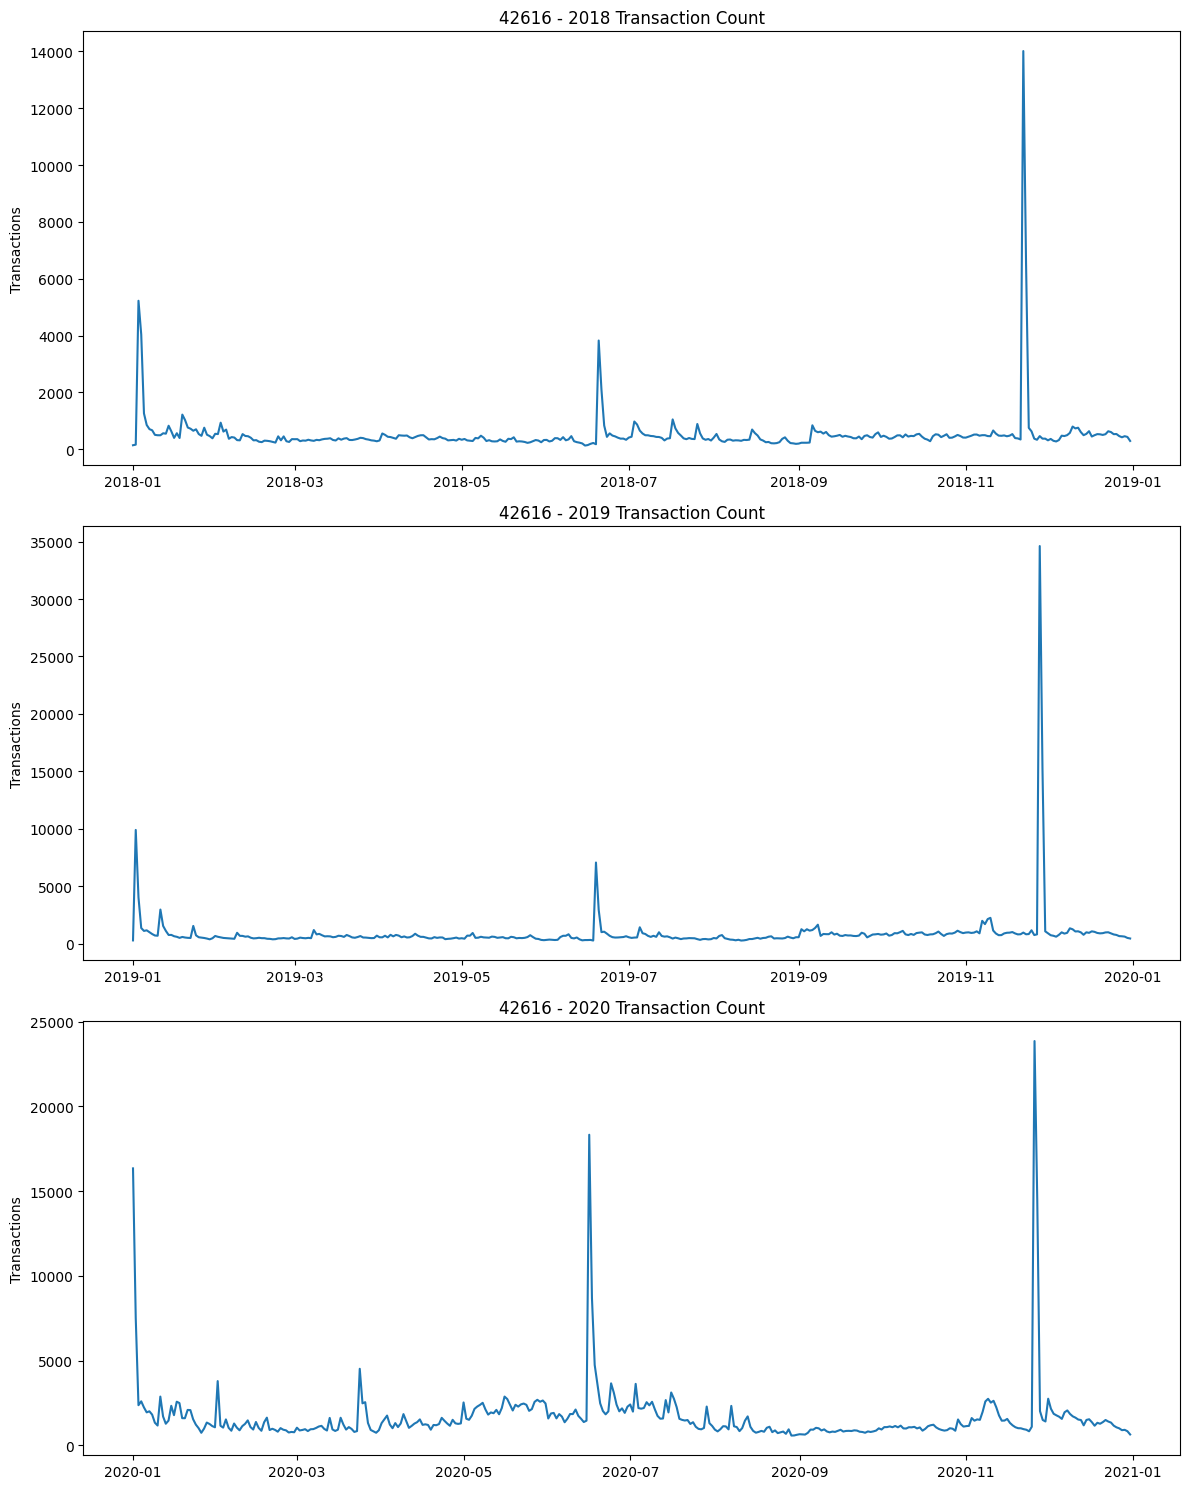

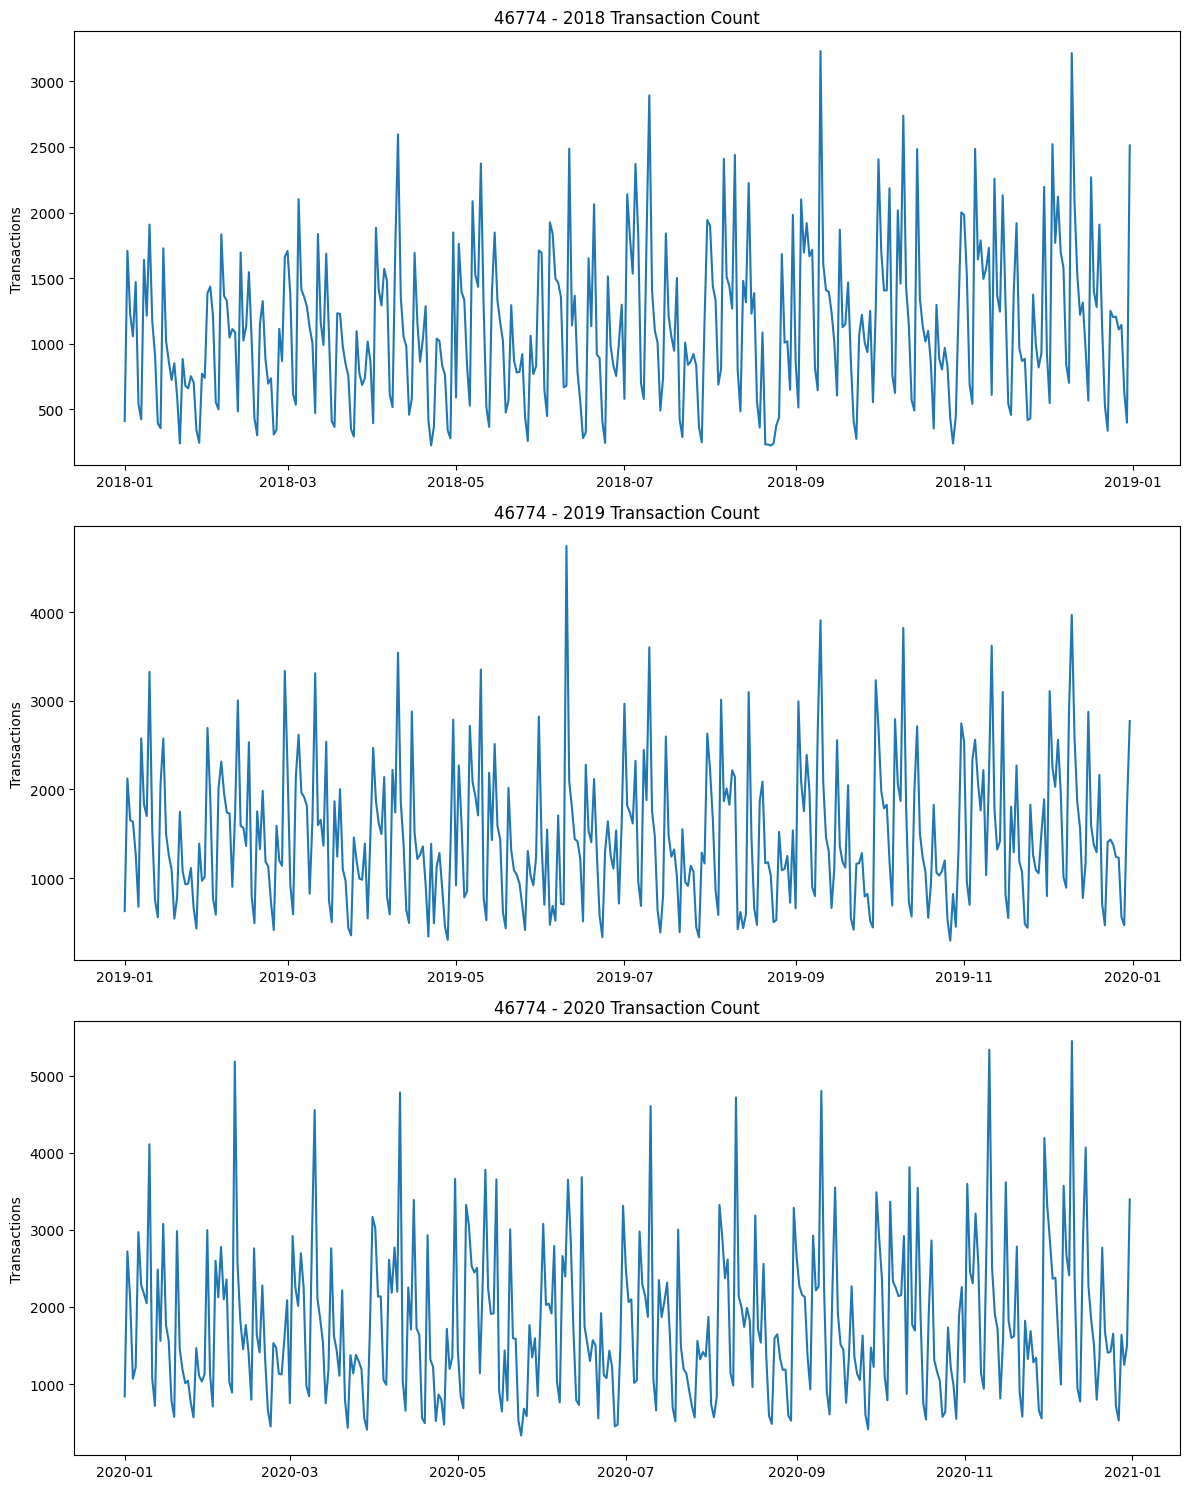

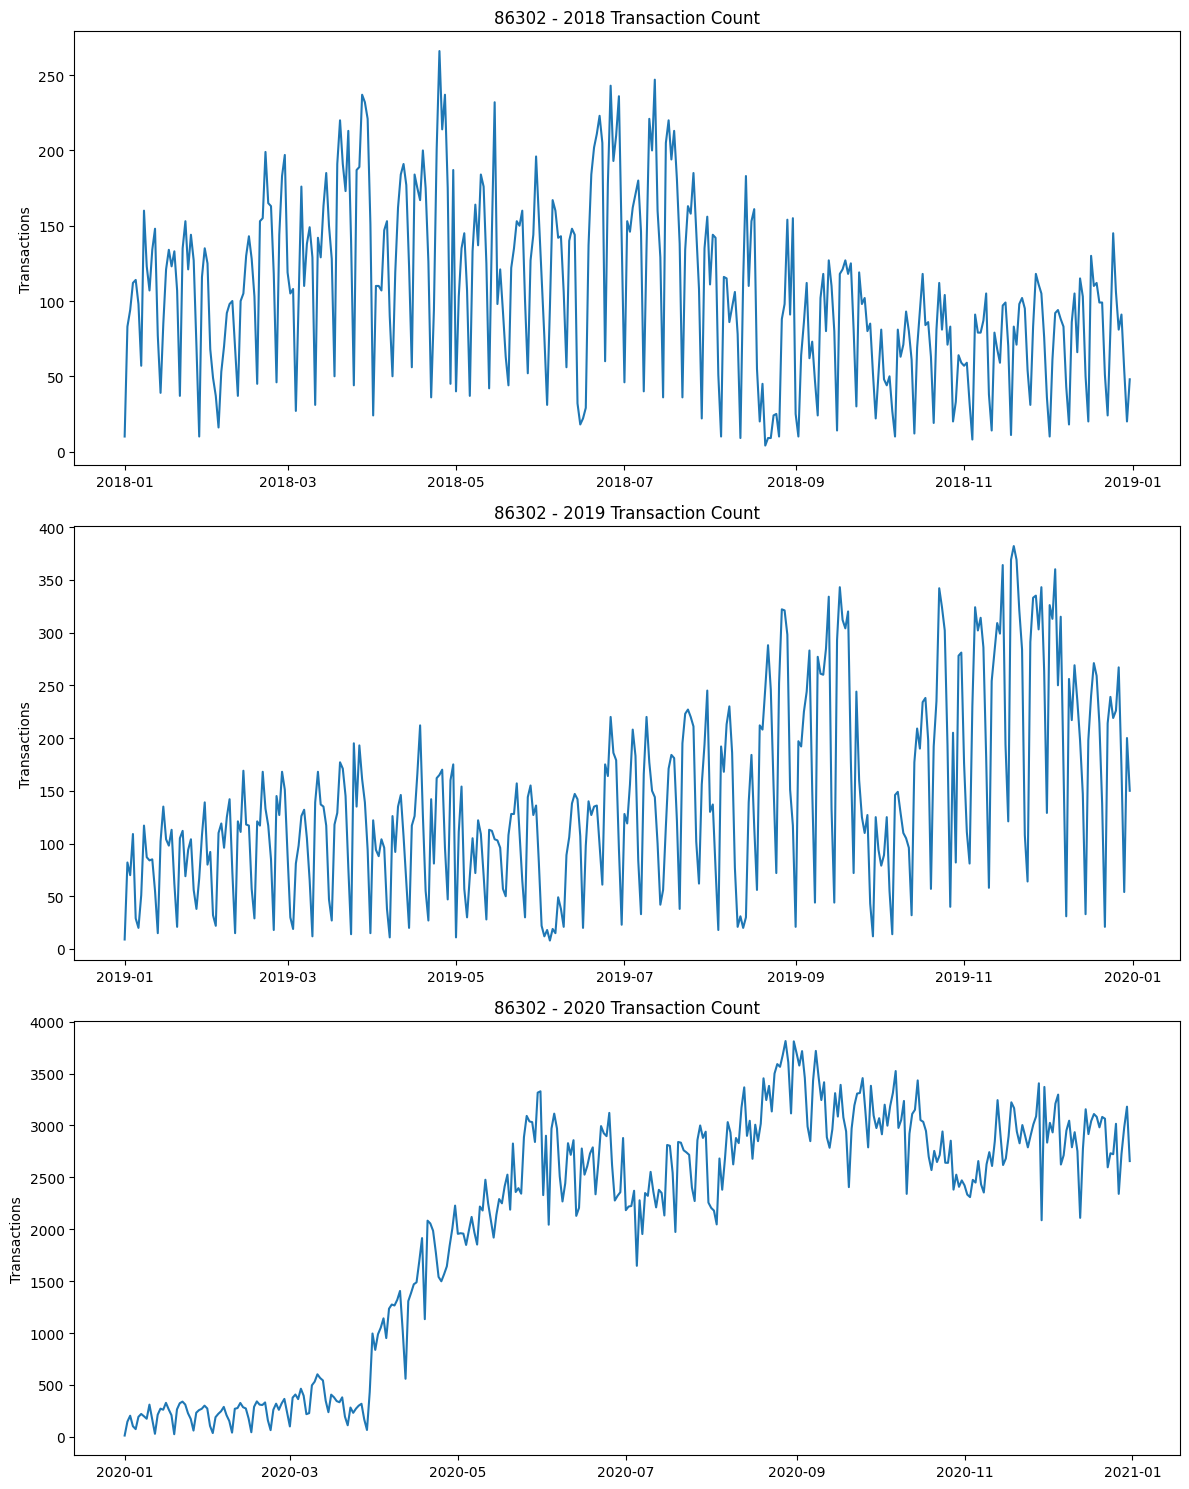

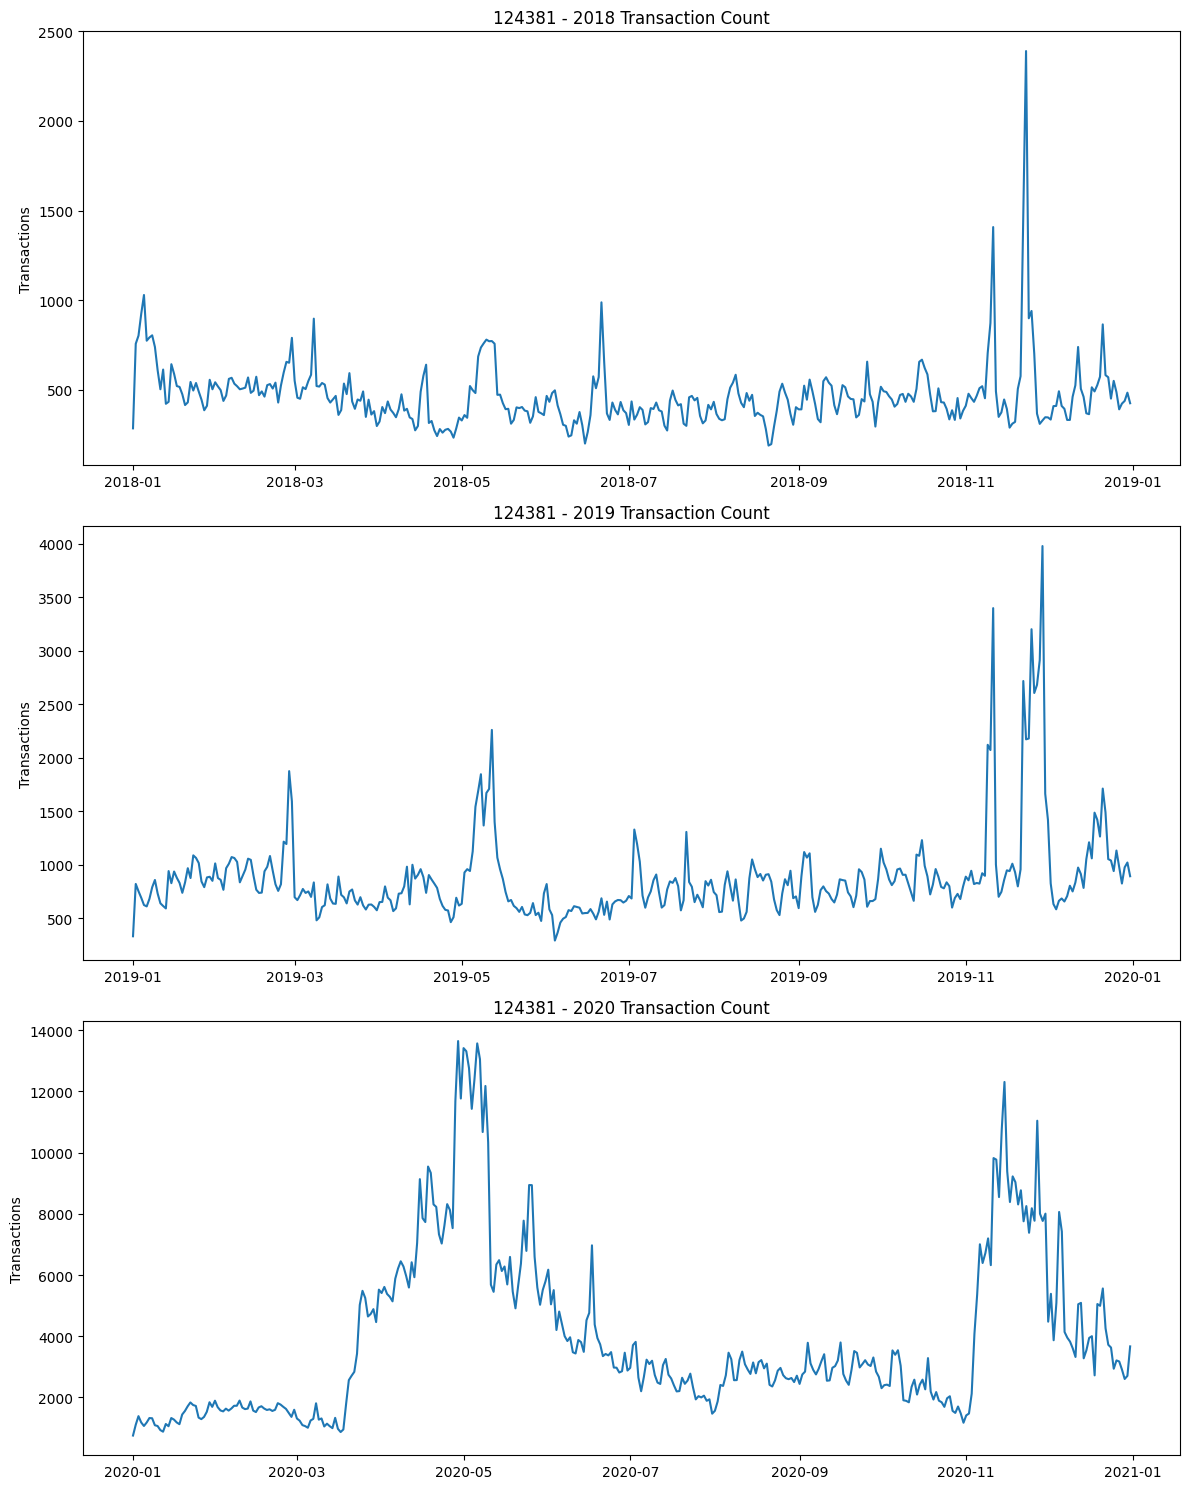

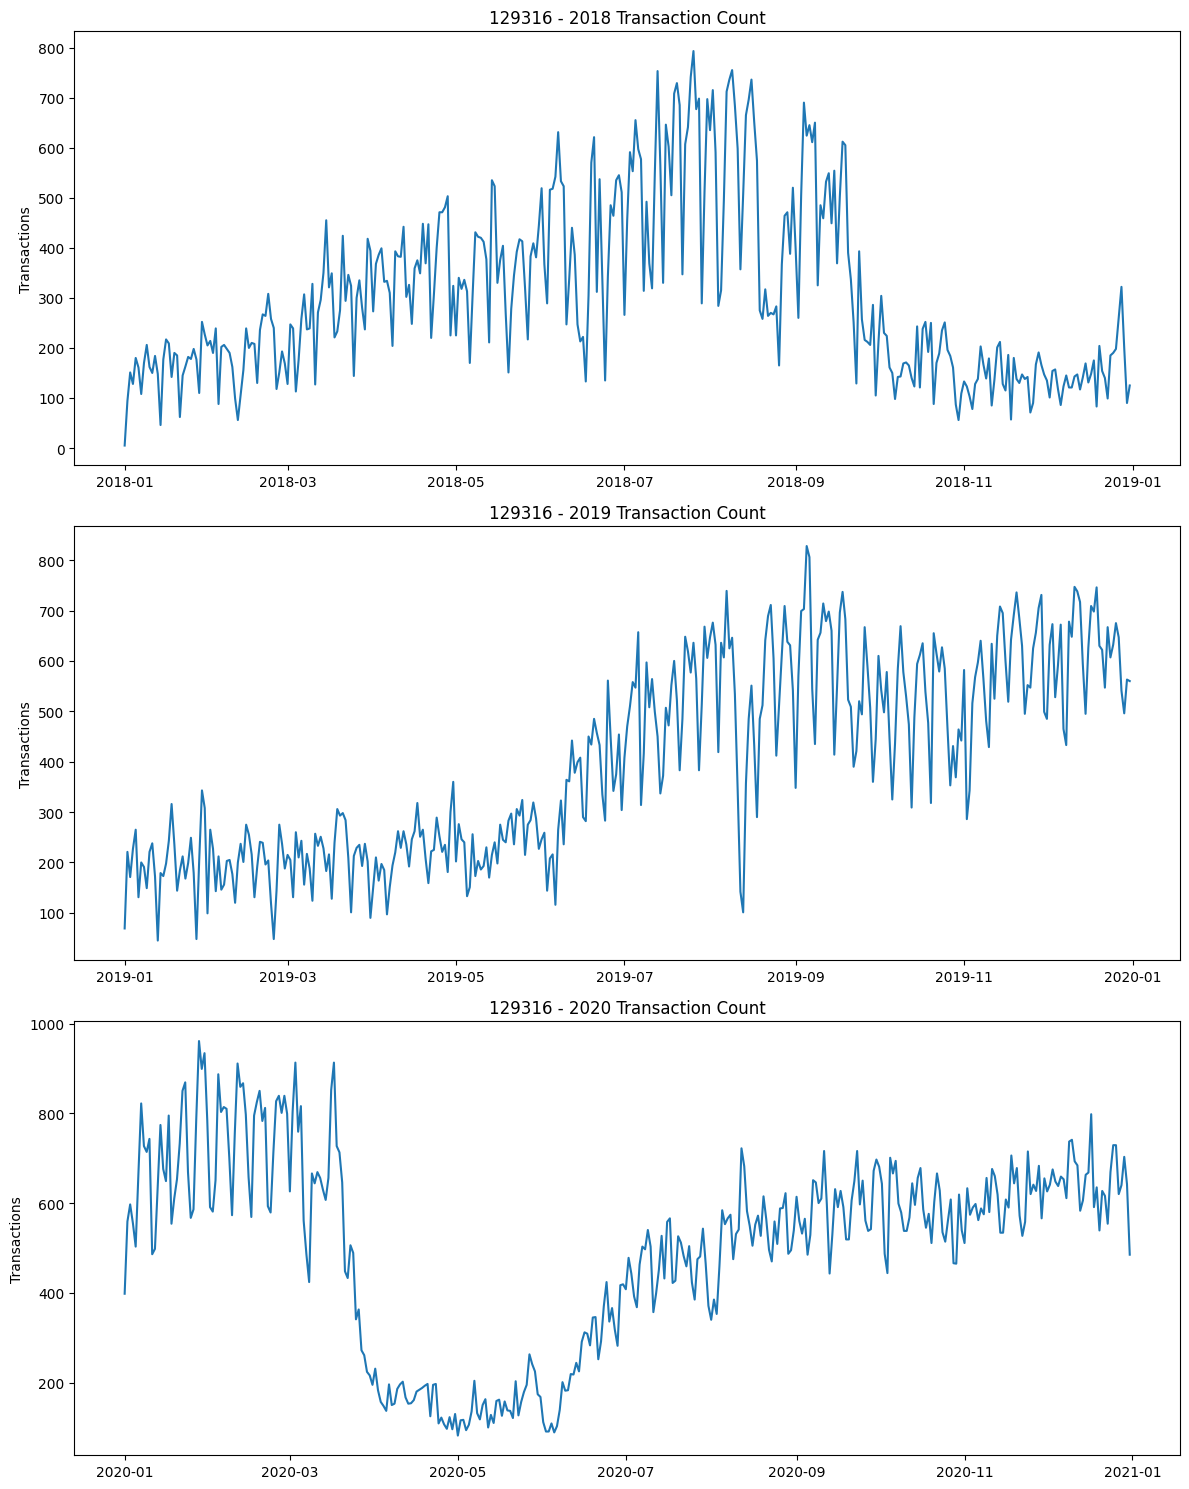

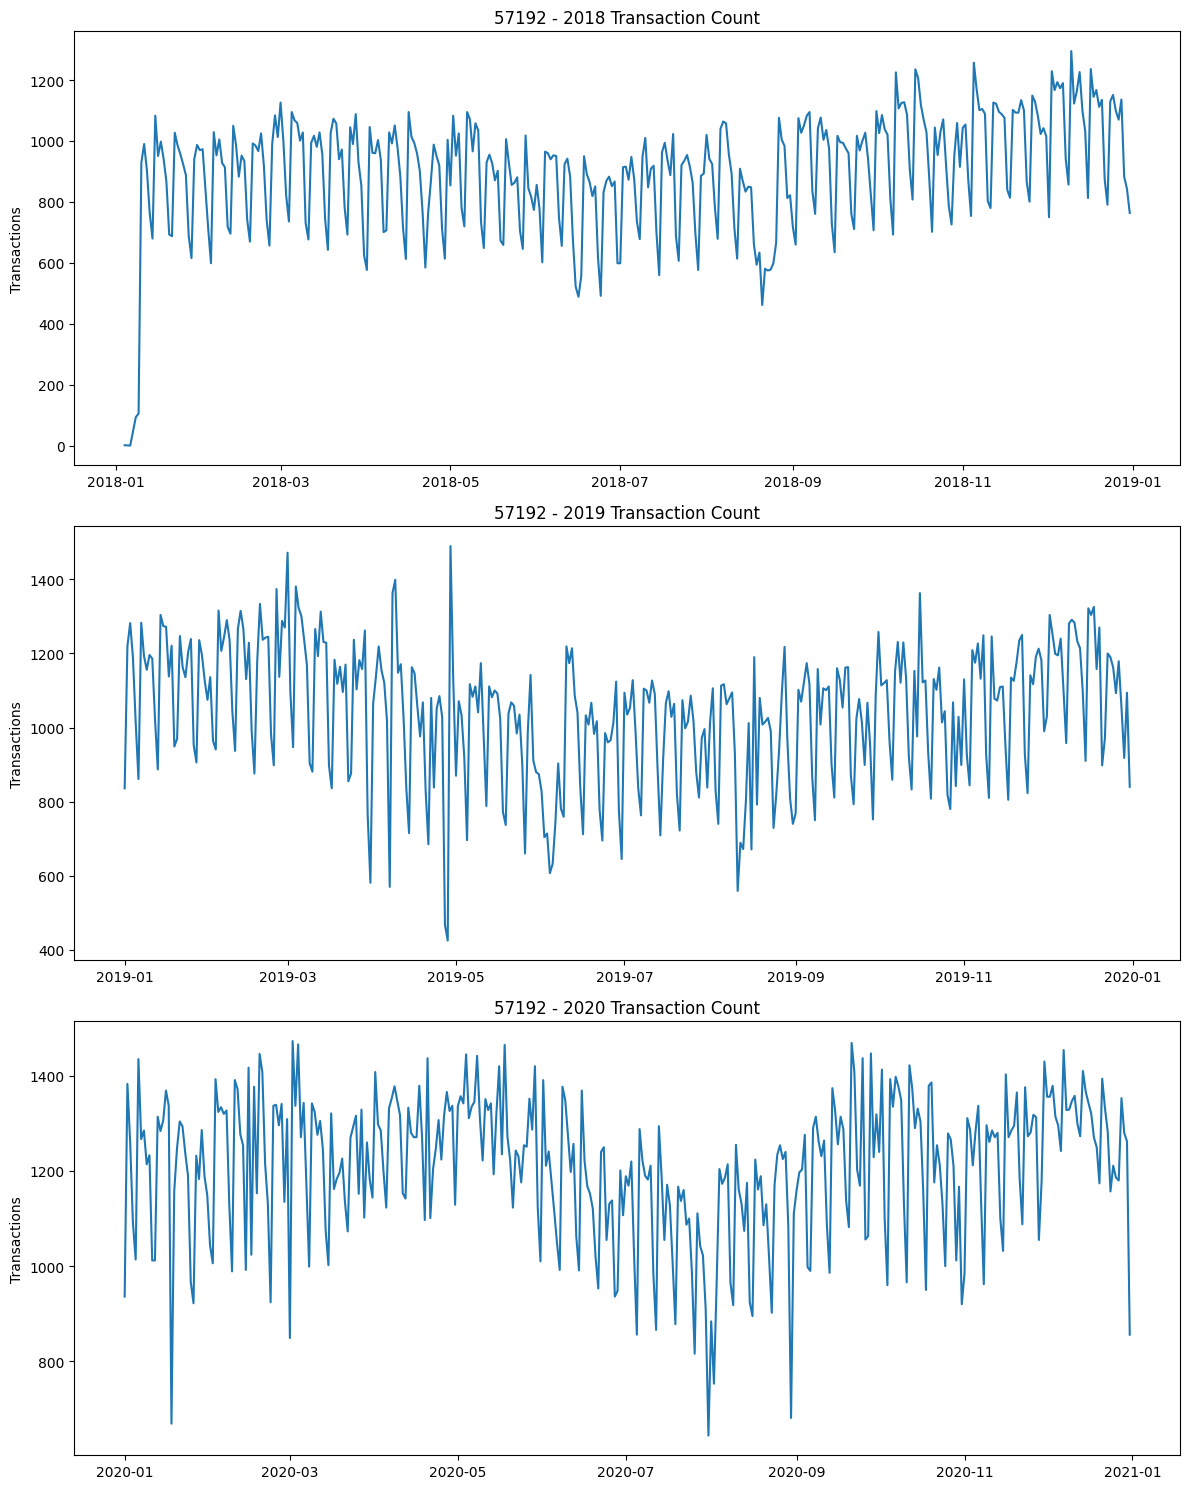

In [54]:
def plot_transaction_trends(df, years):
    for merchant in df["merchant_id"].unique():
        plt.figure(figsize=(12, 5 * len(years)))
        for i, year in enumerate(years):
            plt.subplot(len(years), 1, i+1)
            yearly_data = df[
                (df["merchant_id"] == merchant) &
                (df["transaction_date"] >= f"{year}-01-01") &
                (df["transaction_date"] < f"{year+1}-01-01")
            ]
            plt.plot(yearly_data["transaction_date"], yearly_data["Total_Transaction"])
            plt.title(f"{merchant} - {year} Transaction Count")
            plt.xlabel('')
            plt.ylabel('Transactions')
        plt.tight_layout()
        plt.show()

plot_transaction_trends(df, [2018,2019,2020])

## 3. Feature Engineering

### 3.1. Date Features

We will produce date features to obtain information about trends and capture seasonality.

In [56]:
def create_date_features(df, date_col="transaction_date"):
    df["month"] = df[date_col].dt.month
    df["day_of_month"] = df[date_col].dt.day
    df["day_of_year"] = df[date_col].dt.dayofyear
    df["week_of_year"] = df[date_col].dt.isocalendar().week.astype(int)
    df["day_of_week"] = df[date_col].dt.weekday
    df["year"] = df[date_col].dt.year
    df["is_wknd"] = (df[date_col].dt.weekday >= 5).astype(int)
    df["is_month_start"] = df[date_col].dt.is_month_start.astype(int)
    df["is_month_end"] = df[date_col].dt.is_month_end.astype(int)
    df['quarter'] = df[date_col].dt.quarter
    df['is_quarter_start'] = df[date_col].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_col].dt.is_quarter_end.astype(int)
    df["is_year_start"] = df[date_col].dt.is_year_start.astype(int)
    df["is_year_end"] = df[date_col].dt.is_year_end.astype(int)
    return df

df = create_date_features(df)

In [60]:
df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0

Let's observe the monthly transaction volume of member businesses:

In [63]:
pivot_df = df.pivot_table(
    values = "Total_Transaction",
    index = "merchant_id",
    columns = "month",
    aggfunc="sum",
    fill_value=0
)

pivot_df

month            1       2       3       4       5       6       7       8       9       10      11      12
merchant_id                                                                                                
535           90575   90179   89794   75730   94574  100732  113978  119515  139558  141655  128612  117823
42616        138574   58989   67023   68722   96110  126971   92653   54623   65077   73681  195735   88033
46774        122461  121117  127798  126886  131295  125954  133344  129618  137034  139278  146399  158375
57192         91382   93544  101030   94996   97691   85495   89866   87549   94910  101172  100470  108335
86302         12108   12590   18936   51227   80821   85917   85357  101892  104164   96732   93160   98047
124381        84351   90311  110130  258403  299951  149339  116495  121567  126900  110597  292672  174641
129316        32148   32631   32756   22390   22973   30227   47565   48165   47878   39418   40031   43847

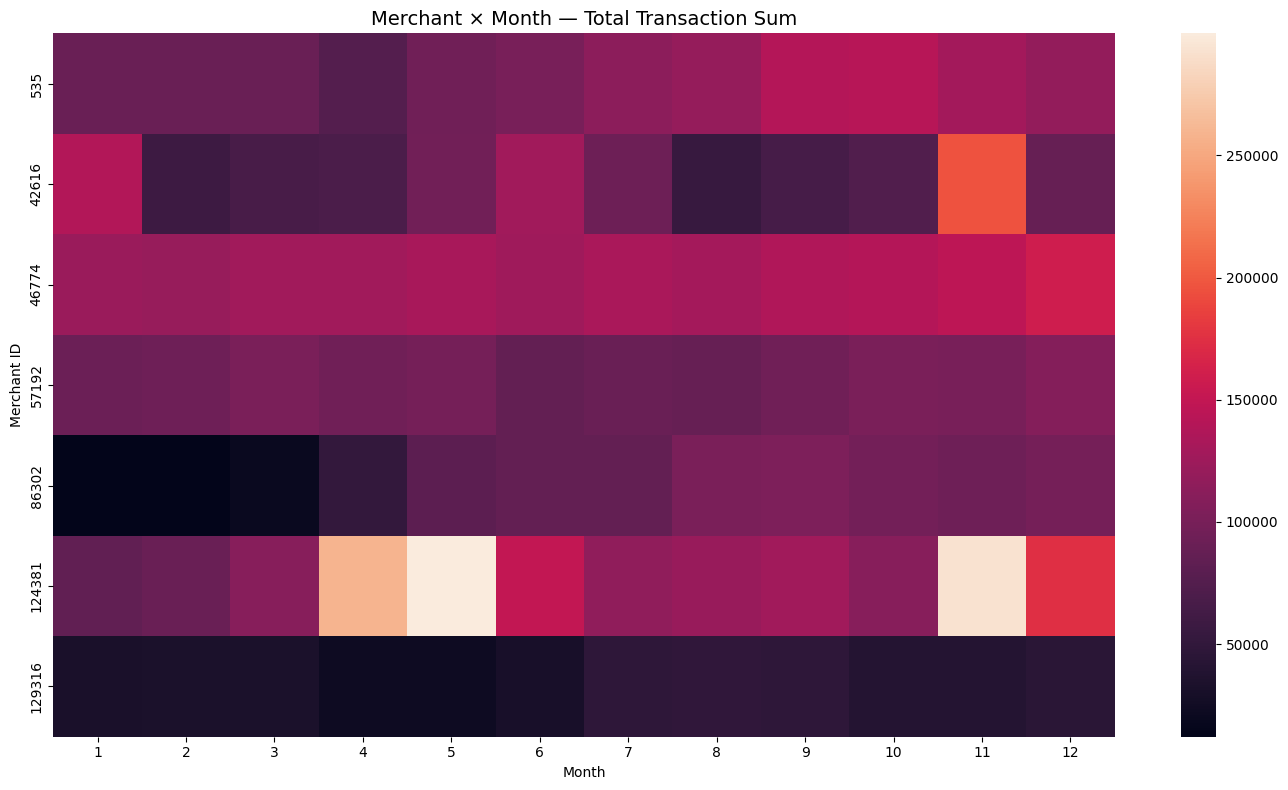

In [65]:
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, annot=False)
plt.title("Merchant × Month — Total Transaction Sum", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Merchant ID")
plt.tight_layout()
plt.show()

In [67]:
# summary of the transaction amount of the merchants by month and year

df.groupby(["merchant_id", "year", "month"]).agg({
    "Total_Transaction": ["sum", "mean", "median"]
})

Total_Transaction                  
                                     sum     mean   median
merchant_id year month                                    
535         2018 1                 20927  675.065  695.000
                 2                 20247  723.107  750.500
                 3                 22807  735.710  725.000
                 4                 22459  748.633  760.500
                 5                 24443  788.484  804.000
                 6                 20376  679.200  748.000
                 7                 23032  742.968  767.000
                 8                 21949  708.032  748.000
                 9                 26982  899.400  932.500
                 10                25516  823.097  830.000
                 11                22573  752.433  795.500
                 12                22091  712.613  774.000
            2019 1                 22586  728.581  753.000
                 2                 22041  787.179  832.000
                 3                 25314  816.581  883.000
                 4                 25862  862.067  899.500
                 5                 31060 1001.935  984.000
                 6                 28917  963.900 1009.500
                 7                 38444 1240.129 1254.000
                 8                 40455 1305.000 1369.000
                 9                 48960 1632.000 1685.000
                 10                52487 1693.129 1778.000
                 11                50443 1681.433 1719.000
                 12                48103 1551.710 1535.000
            2020 1                 47062 1518.129 1600.000
                 2                 47891 1651.414 1691.000
                 3                 41673 1344.290 1322.000
                 4                 27409  913.633  934.500
                 5                 39071 1260.355 1311.000
                 6                 51439 1714.633 1705.500
                 7                 52502 1693.613 1740.000
                 8                 57111 1842.290 1868.000
                 9                 63616 2120.533 2134.500
                 10                63652 2053.290 2077.000
                 11                55596 1853.200 1876.500
                 12                47629 1536.419 1574.000
42616       2018 1                 27226  878.258  564.000
                 2                 11125  397.321  338.500
                 3                 10525  339.516  336.000
                 4                 12337  411.233  409.000
                 5                  9785  315.645  300.000
                 6                 15570  519.000  340.000
                 7                 15684  505.935  434.000
                 8                 10211  329.387  311.000
                 9                 13652  455.067  452.000
                 10                13894  448.194  450.000
                 11                33834 1127.800  476.000
                 12                15559  501.903  496.000
            2019 1                 37578 1212.194  681.000
                 2                 14092  503.286  466.000
                 3                 18545  598.226  567.000
                 4                 16869  562.300  543.000
                 5                 16354  527.548  509.000
                 6                 24531  817.700  527.000
                 7                 17455  563.065  518.000
                 8                 14074  454.000  446.000
                 9                 26056  868.533  808.000
                 10                26816  865.032  868.000
                 11                79683 2656.100  950.500
                 12                26731  862.290  896.000
            2020 1                 73770 2379.677 1713.000
                 2                 33772 1164.552 1037.000
                 3                 37953 1224.290  962.000
                 4                 39516 1317.200 1294.000
                 5                 69971 2257.129 2296.000
           

In [69]:
df.groupby(["merchant_id", "year", "month", "day_of_month"]).agg({"Total_Paid":["sum","mean","median"]})

Total_Paid                          
                                             sum         mean       median
merchant_id year month day_of_month                                       
535         2018 1     1               25883.226    25883.226    25883.226
                       2               60263.928    60263.928    60263.928
                       3               51071.994    51071.994    51071.994
                       4               56995.110    56995.110    56995.110
                       5               66689.352    66689.352    66689.352
                       6               55923.588    55923.588    55923.588
                       7               65682.396    65682.396    65682.396
                       8               65227.608    65227.608    65227.608
                       9               78227.118    78227.118    78227.118
                       10              76767.552    76767.552    76767.552
                       11              59445.396    59445.396    59445.396
                       12              88896.528    88896.528    88896.528
                       13              68158.134    68158.134    68158.134
                       14              53815.896    53815.896    53815.896
                       15              72639.756    72639.756    72639.756
                       16              71088.660    71088.660    71088.660
                       17              71940.006    71940.006    71940.006
                       18              71728.992    71728.992    71728.992
                       19              83748.060    83748.060    83748.060
                       20              61553.664    61553.664    61553.664
                       21              51915.240    51915.240    51915.240
                       22              81066.240    81066.240    81066.240
                       23              78472.242    78472.242    78472.242
                       24              77819.220    77819.220    77819.220
                       25              57784.284    57784.284    57784.284
                       26              77233.734    77233.734    77233.734
                       27              74527.182    74527.182    74527.182
                       28              63374.364    63374.364    63374.364
                       29              72809.280    72809.280    72809.280
                       30              76125.420    76125.420    76125.420
                       31              74357.640    74357.640    74357.640
                 2     1               81568.620    81568.620    81568.620
                       2               69282.540    69282.540    69282.540
                       3               72056.268    72056.268    72056.268
                       4               40240.800    40240.800    40240.800
                       5              103905.846   103905.846   103905.846
                       6               77562.900    77562.900    77562.900
                       7               78742.044    78742.044    78742.044
                       8               73814.940    73814.940    73814.940
                       9               56841.462    56841.462    56841.462
                       10              90836.316    90836.316    90836.316
                       11              63497.466    63497.466    63497.466
                       12              97862.832    97862.832    97862.832
                       13              78230.700    78230.700    78230.700
                       14              61950.240    61950.240    61950.240
                       15              61182.324    61182.324    61182.324
                       16              79034.724    79034.724    79034.724
                       17              70368.228    70368.228    70368.228
                       18              32424.840    32424.840    32424.840
                       19              85035.060    85035.060    85035.060
                       20              91835.280    91835.280  

### 3.2 Lag/Shifted Features

Lag values will be generated using the Total_Transaction variable. When we generate these values, random noise is added to the dataset to prevent overfitting.

In [73]:
## Random Noise:

def random_noise(dataframe):
    return np.random.normal(scale = 1.6, size = (len(dataframe),))

In [75]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["transaction_lag_" + str(lag)] = dataframe.groupby(["merchant_id"])["Total_Transaction"].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  transaction_lag_91  transaction_lag_92  transaction_lag_170  transaction_lag_171  transaction_lag_172  transaction_lag_173  transaction_lag_174  transaction_lag_175  transaction_lag_176  transaction_lag_177  transaction_lag_178  transaction_lag_179  \
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   

   transaction_lag_180  transaction_lag_181  transaction_lag_182  transaction_lag_183  transaction_lag_184  transaction_lag_185  transaction_lag_186  transaction_lag_187  transaction_lag_188  transaction_lag_189  transaction_lag_190  transaction_lag_350  transaction_lag_351  transaction_lag_352  transaction_lag_354  transaction_lag_355  transaction_lag_356  transaction_lag_357  transaction_lag_358  transaction_lag_359  transaction_lag_360  transaction_lag_361  transaction_lag_362  \
0                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

### 3.3. Rolling Mean Features

In [77]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["transaction_roll_mean_" + str(window)] = dataframe.groupby(["merchant_id"])["Total_Transaction"]. \
                                                        transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df,[91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

In [79]:
df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  transaction_lag_91  transaction_lag_92  transaction_lag_170  transaction_lag_171  transaction_lag_172  transaction_lag_173  transaction_lag_174  transaction_lag_175  transaction_lag_176  transaction_lag_177  transaction_lag_178  transaction_lag_179  \
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   

   transaction_lag_180  transaction_lag_181  transaction_lag_182  transaction_lag_183  transaction_lag_184  transaction_lag_185  transaction_lag_186  transaction_lag_187  transaction_lag_188  transaction_lag_189  transaction_lag_190  transaction_lag_350  transaction_lag_351  transaction_lag_352  transaction_lag_354  transaction_lag_355  transaction_lag_356  transaction_lag_357  transaction_lag_358  transaction_lag_359  transaction_lag_360  transaction_lag_361  transaction_lag_362  \
0                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

### 3.4. Exponentially Weighted Mean Features

Exponentially weighted averages are added to the data set according to different alpha values.

In [81]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["transaction_ewm_alpha_" + str(alpha).replace(".","") + str(lag)] = \
                dataframe.groupby(["merchant_id"])["Total_Transaction"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)

df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  transaction_lag_91  transaction_lag_92  transaction_lag_170  transaction_lag_171  transaction_lag_172  transaction_lag_173  transaction_lag_174  transaction_lag_175  transaction_lag_176  transaction_lag_177  transaction_lag_178  transaction_lag_179  \
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   

   transaction_lag_180  transaction_lag_181  transaction_lag_182  transaction_lag_183  transaction_lag_184  transaction_lag_185  transaction_lag_186  transaction_lag_187  transaction_lag_188  transaction_lag_189  transaction_lag_190  transaction_lag_350  transaction_lag_351  transaction_lag_352  transaction_lag_354  transaction_lag_355  transaction_lag_356  transaction_lag_357  transaction_lag_358  transaction_lag_359  transaction_lag_360  transaction_lag_361  transaction_lag_362  \
0                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

### 3.5. Special Days Features

In [83]:
# Black Friday

def is_black_friday(date):
    if date.month == 11:
        month_days = pd.date_range(start=date.replace(day=1), end=date.replace(day=30))
        fridays = [d for d in month_days if d.weekday() == 4]
        last_friday = fridays[-1]
        return int(date == last_friday)
    return 0

df["is_black_friday"] = df["transaction_date"].apply(is_black_friday)

In [85]:
def is_summer_solstice(date):
    return int(date.month == 6 and date.day in [19, 20, 21, 22])

df["is_summer_solstice"] = df["transaction_date"].apply(is_summer_solstice)

In [87]:
# Black Week

df["is_black_week"] = df["transaction_date"].apply(lambda x: int(x.month == 11 and x.week >= 47))

In [89]:
# Salary Payment Effect

df["is_salary_period"] = df["day_of_month"].between(1, 5).astype(int)

## 4. One-Hot-Encoding

In [91]:
df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  transaction_lag_91  transaction_lag_92  transaction_lag_170  transaction_lag_171  transaction_lag_172  transaction_lag_173  transaction_lag_174  transaction_lag_175  transaction_lag_176  transaction_lag_177  transaction_lag_178  transaction_lag_179  \
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   

   transaction_lag_180  transaction_lag_181  transaction_lag_182  transaction_lag_183  transaction_lag_184  transaction_lag_185  transaction_lag_186  transaction_lag_187  transaction_lag_188  transaction_lag_189  transaction_lag_190  transaction_lag_350  transaction_lag_351  transaction_lag_352  transaction_lag_354  transaction_lag_355  transaction_lag_356  transaction_lag_357  transaction_lag_358  transaction_lag_359  transaction_lag_360  transaction_lag_361  transaction_lag_362  \
0                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

In [93]:
df = pd.get_dummies(df, columns=["merchant_id","day_of_week","month"], dtype=int)

## 5. Log of Dependent Variable

In [95]:
df["Total_Transaction"] = np.log1p(df["Total_Transaction"].values)

## 6. Custom Cost Function

SMAPE: Symetric mean absolute percentage error (adjusted MAPE)

In [98]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num/denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels=train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return "SMAPE", smape_val, False

## 7. Time-Based Validation Sets

The final three months of 2020 are to be forecasted. We will use the final three months of 2019 as the validation set.

In [100]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train = df.loc[(df["transaction_date"]< "2019-10-01"), :]
val = df.loc[(df["transaction_date"] >= "2019-10-01") & (df["transaction_date"] < "2020-01-01"), :]

cols = [col for col in train.columns if col not in ["transaction_date", "Total_Transaction", "Total_Paid", "year"]]

Y_train = train["Total_Transaction"]
X_train = train[cols]

Y_val = val["Total_Transaction"]
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((4461,), (4461, 214), (644,), (644, 214))

In [102]:
lgbtrain = lgb.Dataset(data = X_train, label = Y_train, feature_name=cols)
lgbval = lgb.Dataset(data = X_val, label = Y_val, reference=lgbtrain, feature_name=cols)

## 8. Time Series Model with LGBM

We will forecast member merchant transaction volumes using the LGBM model for the last three months of 2020. Beforehand, we will conduct hyperparameter optimization with optuna.

### 8.1 Hyperparameter Optimization

In [105]:
import optuna
from sklearn.metrics import mean_absolute_error, make_scorer

In [107]:
def objective(trial):
    param_grid = {
        "metric": {'mae'},
        "verbosity":-1,
        "objective": "regression",
        "nthread": -1,
        "num_leaves": trial.suggest_int("num_leaves",10,100),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.9),
        "max_depth": trial.suggest_int("max_depth", -1, 10)
    }

    model = lgb.train(
        param_grid,
        lgbtrain,
        valid_sets=[lgbtrain,lgbval],
        num_boost_round = 5000,
        feval = lgbm_smape,
        callbacks=[
            lgb.early_stopping(200),
            lgb.log_evaluation(period=100)
        ]
    )

    valid_name = list(model.best_score.keys())[-1]
    metric_name = list(model.best_score[valid_name].keys())[0]
    best_smape = model.best_score[valid_name][metric_name]

    # Print best SMAPE from LightGBM during this trial
    print(f"Trial {trial.number} - Best {metric_name}: {round(best_smape, 4)}")

    trial.set_user_attr("best_smape", best_smape)
    trial.set_user_attr("best_iteration", model.best_iteration)

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    score = mean_absolute_error(np.expm1(Y_val), np.expm1(y_pred))

    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best trial
best_trial = study.best_trial

print("Best trial params:", best_trial.params)
print("Best SMAPE across trials:", best_trial.user_attrs["best_smape"])
best_iteration = best_trial.user_attrs["best_iteration"]
print("Best iteration:", best_iteration)

[I 2025-12-10 12:30:23,483] A new study created in memory with name: no-name-c5c0dd06-da88-49ec-9240-59412ba46322


Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.161405	training's SMAPE: 15.8034	valid_1's l1: 0.305323	valid_1's SMAPE: 29.0918
[200]	training's l1: 0.128437	training's SMAPE: 12.6419	valid_1's l1: 0.312903	valid_1's SMAPE: 29.8033


[I 2025-12-10 12:30:24,814] Trial 0 finished with value: 297.44826594973443 and parameters: {'num_leaves': 10, 'learning_rate': 0.15482519954113785, 'feature_fraction': 0.5780598617737642, 'max_depth': 0}. Best is trial 0 with value: 297.44826594973443.


Early stopping, best iteration is:
[47]	training's l1: 0.195672	training's SMAPE: 19.0415	valid_1's l1: 0.299506	valid_1's SMAPE: 28.5722
Trial 0 - Best l1: 0.2995
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.280434	training's SMAPE: 26.9148	valid_1's l1: 0.294562	valid_1's SMAPE: 28.175
[200]	training's l1: 0.267523	training's SMAPE: 25.7335	valid_1's l1: 0.292011	valid_1's SMAPE: 27.9676
[300]	training's l1: 0.259508	training's SMAPE: 25.0005	valid_1's l1: 0.293044	valid_1's SMAPE: 28.0997
[400]	training's l1: 0.253761	training's SMAPE: 24.4781	valid_1's l1: 0.298639	valid_1's SMAPE: 28.6527


[I 2025-12-10 12:30:25,683] Trial 1 finished with value: 320.35212196243094 and parameters: {'num_leaves': 27, 'learning_rate': 0.19369131716148466, 'feature_fraction': 0.16029482461645284, 'max_depth': 1}. Best is trial 0 with value: 297.44826594973443.


Early stopping, best iteration is:
[252]	training's l1: 0.263151	training's SMAPE: 25.3352	valid_1's l1: 0.289675	valid_1's SMAPE: 27.7683
Trial 1 - Best l1: 0.2897
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.185011	training's SMAPE: 17.9559	valid_1's l1: 0.321613	valid_1's SMAPE: 30.6451
[200]	training's l1: 0.141906	training's SMAPE: 13.8608	valid_1's l1: 0.314121	valid_1's SMAPE: 29.8516
[300]	training's l1: 0.123024	training's SMAPE: 12.0457	valid_1's l1: 0.319787	valid_1's SMAPE: 30.3732


[I 2025-12-10 12:30:31,220] Trial 2 finished with value: 315.5204113280237 and parameters: {'num_leaves': 40, 'learning_rate': 0.028394488802003036, 'feature_fraction': 0.2351423109274734, 'max_depth': 10}. Best is trial 0 with value: 297.44826594973443.


[400]	training's l1: 0.109193	training's SMAPE: 10.7006	valid_1's l1: 0.325016	valid_1's SMAPE: 30.8418
Early stopping, best iteration is:
[209]	training's l1: 0.140258	training's SMAPE: 13.7029	valid_1's l1: 0.313554	valid_1's SMAPE: 29.8018
Trial 2 - Best l1: 0.3136
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.140136	training's SMAPE: 13.7313	valid_1's l1: 0.342177	valid_1's SMAPE: 32.5017
[200]	training's l1: 0.106688	training's SMAPE: 10.5183	valid_1's l1: 0.34584	valid_1's SMAPE: 32.8794


[I 2025-12-10 12:30:32,756] Trial 3 finished with value: 309.62740593796724 and parameters: {'num_leaves': 95, 'learning_rate': 0.16346094855053717, 'feature_fraction': 0.5526079537653458, 'max_depth': 5}. Best is trial 0 with value: 297.44826594973443.


Early stopping, best iteration is:
[56]	training's l1: 0.162855	training's SMAPE: 15.902	valid_1's l1: 0.330007	valid_1's SMAPE: 31.3808
Trial 3 - Best l1: 0.33
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.158748	training's SMAPE: 15.5522	valid_1's l1: 0.299645	valid_1's SMAPE: 28.5911
[200]	training's l1: 0.127283	training's SMAPE: 12.5144	valid_1's l1: 0.298085	valid_1's SMAPE: 28.4788
Early stopping, best iteration is:
[52]	training's l1: 0.189809	training's SMAPE: 18.4892	valid_1's l1: 0.278033	valid_1's SMAPE: 26.635
Trial 4 - Best l1: 0.278


[I 2025-12-10 12:30:33,932] Trial 4 finished with value: 288.69295652968185 and parameters: {'num_leaves': 10, 'learning_rate': 0.18425230816088464, 'feature_fraction': 0.3169375958487407, 'max_depth': 6}. Best is trial 4 with value: 288.69295652968185.


Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.249831	training's SMAPE: 24.0824	valid_1's l1: 0.284053	valid_1's SMAPE: 27.1956
[200]	training's l1: 0.214597	training's SMAPE: 20.7939	valid_1's l1: 0.308677	valid_1's SMAPE: 29.5467


[I 2025-12-10 12:30:34,517] Trial 5 finished with value: 315.6904649895086 and parameters: {'num_leaves': 62, 'learning_rate': 0.117456916328888, 'feature_fraction': 0.1865828178963093, 'max_depth': 2}. Best is trial 4 with value: 288.69295652968185.


Early stopping, best iteration is:
[55]	training's l1: 0.268521	training's SMAPE: 25.8108	valid_1's l1: 0.273911	valid_1's SMAPE: 26.2108
Trial 5 - Best l1: 0.2739
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.194479	training's SMAPE: 18.8339	valid_1's l1: 0.303869	valid_1's SMAPE: 29.0078
[200]	training's l1: 0.169775	training's SMAPE: 16.5336	valid_1's l1: 0.300043	valid_1's SMAPE: 28.6102
[300]	training's l1: 0.155125	training's SMAPE: 15.1502	valid_1's l1: 0.302198	valid_1's SMAPE: 28.8108


[I 2025-12-10 12:30:37,273] Trial 6 finished with value: 302.45193813597234 and parameters: {'num_leaves': 36, 'learning_rate': 0.037598872750103485, 'feature_fraction': 0.2577367857711239, 'max_depth': 5}. Best is trial 4 with value: 288.69295652968185.


[400]	training's l1: 0.143469	training's SMAPE: 14.0355	valid_1's l1: 0.305868	valid_1's SMAPE: 29.1539
Early stopping, best iteration is:
[226]	training's l1: 0.166036	training's SMAPE: 16.1837	valid_1's l1: 0.299004	valid_1's SMAPE: 28.5111
Trial 6 - Best l1: 0.299
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.146928	training's SMAPE: 14.3762	valid_1's l1: 0.31933	valid_1's SMAPE: 30.3086
[200]	training's l1: 0.113481	training's SMAPE: 11.1342	valid_1's l1: 0.322652	valid_1's SMAPE: 30.6085


[I 2025-12-10 12:30:40,611] Trial 7 finished with value: 301.9988284054672 and parameters: {'num_leaves': 28, 'learning_rate': 0.07258688398799008, 'feature_fraction': 0.6449752390690883, 'max_depth': 8}. Best is trial 4 with value: 288.69295652968185.


[300]	training's l1: 0.0939434	training's SMAPE: 9.25708	valid_1's l1: 0.336909	valid_1's SMAPE: 31.9625
Early stopping, best iteration is:
[106]	training's l1: 0.145002	training's SMAPE: 14.1914	valid_1's l1: 0.318224	valid_1's SMAPE: 30.2027
Trial 7 - Best l1: 0.3182
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0878821	training's SMAPE: 8.65078	valid_1's l1: 0.352932	valid_1's SMAPE: 33.2154


[I 2025-12-10 12:30:43,425] Trial 8 finished with value: 357.0057099854947 and parameters: {'num_leaves': 94, 'learning_rate': 0.14991985540720934, 'feature_fraction': 0.4621934309704424, 'max_depth': 9}. Best is trial 4 with value: 288.69295652968185.


[200]	training's l1: 0.0632585	training's SMAPE: 6.2615	valid_1's l1: 0.349165	valid_1's SMAPE: 32.8754
Early stopping, best iteration is:
[14]	training's l1: 0.175344	training's SMAPE: 17.0002	valid_1's l1: 0.337906	valid_1's SMAPE: 32.1365
Trial 8 - Best l1: 0.3379
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.221827	training's SMAPE: 21.4125	valid_1's l1: 0.323644	valid_1's SMAPE: 30.9257
[200]	training's l1: 0.19889	training's SMAPE: 19.299	valid_1's l1: 0.301197	valid_1's SMAPE: 28.7892
[300]	training's l1: 0.186272	training's SMAPE: 18.1282	valid_1's l1: 0.301522	valid_1's SMAPE: 28.8192


[I 2025-12-10 12:30:45,349] Trial 9 finished with value: 299.57510664279107 and parameters: {'num_leaves': 13, 'learning_rate': 0.03385995928082918, 'feature_fraction': 0.4097310478140329, 'max_depth': 4}. Best is trial 4 with value: 288.69295652968185.


[400]	training's l1: 0.173189	training's SMAPE: 16.8992	valid_1's l1: 0.314628	valid_1's SMAPE: 29.993
Early stopping, best iteration is:
[239]	training's l1: 0.19371	training's SMAPE: 18.8201	valid_1's l1: 0.298675	valid_1's SMAPE: 28.5542
Trial 9 - Best l1: 0.2987
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0973975	training's SMAPE: 9.60304	valid_1's l1: 0.347252	valid_1's SMAPE: 32.9826
[200]	training's l1: 0.0706476	training's SMAPE: 7.00709	valid_1's l1: 0.353369	valid_1's SMAPE: 33.5273


[I 2025-12-10 12:30:47,793] Trial 10 finished with value: 333.4110533551605 and parameters: {'num_leaves': 64, 'learning_rate': 0.195988652427068, 'feature_fraction': 0.843449555154298, 'max_depth': 7}. Best is trial 4 with value: 288.69295652968185.


Early stopping, best iteration is:
[37]	training's l1: 0.135981	training's SMAPE: 13.3025	valid_1's l1: 0.339944	valid_1's SMAPE: 32.315
Trial 10 - Best l1: 0.3399
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.157915	training's SMAPE: 15.4533	valid_1's l1: 0.301966	valid_1's SMAPE: 28.7385
[200]	training's l1: 0.123987	training's SMAPE: 12.1932	valid_1's l1: 0.301414	valid_1's SMAPE: 28.6413


[I 2025-12-10 12:30:49,556] Trial 11 finished with value: 288.69574849275955 and parameters: {'num_leaves': 12, 'learning_rate': 0.13376671921943692, 'feature_fraction': 0.630875029438228, 'max_depth': -1}. Best is trial 4 with value: 288.69295652968185.


Early stopping, best iteration is:
[56]	training's l1: 0.183274	training's SMAPE: 17.8605	valid_1's l1: 0.27975	valid_1's SMAPE: 26.7201
Trial 11 - Best l1: 0.2798
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.172969	training's SMAPE: 16.8912	valid_1's l1: 0.313863	valid_1's SMAPE: 29.9209
[200]	training's l1: 0.139209	training's SMAPE: 13.6669	valid_1's l1: 0.315651	valid_1's SMAPE: 30.0171


[I 2025-12-10 12:30:51,141] Trial 12 finished with value: 295.32218415269097 and parameters: {'num_leaves': 10, 'learning_rate': 0.11715054952415013, 'feature_fraction': 0.6970995812646044, 'max_depth': -1}. Best is trial 4 with value: 288.69295652968185.


Early stopping, best iteration is:
[62]	training's l1: 0.192459	training's SMAPE: 18.7184	valid_1's l1: 0.300962	valid_1's SMAPE: 28.7446
Trial 12 - Best l1: 0.301
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.219216	training's SMAPE: 21.2025	valid_1's l1: 0.274431	valid_1's SMAPE: 26.3012
[200]	training's l1: 0.191157	training's SMAPE: 18.6041	valid_1's l1: 0.299351	valid_1's SMAPE: 28.6162


[I 2025-12-10 12:30:52,280] Trial 13 finished with value: 291.3091660588154 and parameters: {'num_leaves': 50, 'learning_rate': 0.08367213763732939, 'feature_fraction': 0.3664005966007577, 'max_depth': 3}. Best is trial 4 with value: 288.69295652968185.


Early stopping, best iteration is:
[93]	training's l1: 0.222206	training's SMAPE: 21.48	valid_1's l1: 0.271552	valid_1's SMAPE: 26.0313
Trial 13 - Best l1: 0.2716
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.128272	training's SMAPE: 12.5707	valid_1's l1: 0.370782	valid_1's SMAPE: 34.9326


[I 2025-12-10 12:30:53,854] Trial 14 finished with value: 371.44206808665 and parameters: {'num_leaves': 77, 'learning_rate': 0.14073710697934178, 'feature_fraction': 0.3453354851713519, 'max_depth': 6}. Best is trial 4 with value: 288.69295652968185.


[200]	training's l1: 0.0991031	training's SMAPE: 9.76276	valid_1's l1: 0.387233	valid_1's SMAPE: 36.4951
Early stopping, best iteration is:
[15]	training's l1: 0.213751	training's SMAPE: 20.6682	valid_1's l1: 0.35638	valid_1's SMAPE: 33.9473
Trial 14 - Best l1: 0.3564
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.187019	training's SMAPE: 18.221	valid_1's l1: 0.307448	valid_1's SMAPE: 29.3906


[I 2025-12-10 12:30:54,872] Trial 15 finished with value: 288.06645300989595 and parameters: {'num_leaves': 25, 'learning_rate': 0.17258690194068133, 'feature_fraction': 0.7778600022094457, 'max_depth': 3}. Best is trial 15 with value: 288.06645300989595.


[200]	training's l1: 0.153827	training's SMAPE: 15.0686	valid_1's l1: 0.308149	valid_1's SMAPE: 29.3886
Early stopping, best iteration is:
[44]	training's l1: 0.219874	training's SMAPE: 21.2908	valid_1's l1: 0.266884	valid_1's SMAPE: 25.5686
Trial 15 - Best l1: 0.2669
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.181444	training's SMAPE: 17.6914	valid_1's l1: 0.319612	valid_1's SMAPE: 30.4376


[I 2025-12-10 12:30:55,879] Trial 16 finished with value: 294.9781548547221 and parameters: {'num_leaves': 24, 'learning_rate': 0.17854914857085638, 'feature_fraction': 0.8802774853585249, 'max_depth': 3}. Best is trial 15 with value: 288.06645300989595.


[200]	training's l1: 0.151068	training's SMAPE: 14.8047	valid_1's l1: 0.335101	valid_1's SMAPE: 31.8134
Early stopping, best iteration is:
[45]	training's l1: 0.215174	training's SMAPE: 20.8477	valid_1's l1: 0.283311	valid_1's SMAPE: 27.1658
Trial 16 - Best l1: 0.2833
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.103362	training's SMAPE: 10.1858	valid_1's l1: 0.365525	valid_1's SMAPE: 34.3954


[I 2025-12-10 12:30:57,916] Trial 17 finished with value: 368.4664967568569 and parameters: {'num_leaves': 42, 'learning_rate': 0.1745500121003178, 'feature_fraction': 0.7579449986437348, 'max_depth': 7}. Best is trial 15 with value: 288.06645300989595.


[200]	training's l1: 0.075215	training's SMAPE: 7.45836	valid_1's l1: 0.369694	valid_1's SMAPE: 34.662
Early stopping, best iteration is:
[12]	training's l1: 0.199285	training's SMAPE: 19.336	valid_1's l1: 0.347908	valid_1's SMAPE: 33.2356
Trial 17 - Best l1: 0.3479
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.185114	training's SMAPE: 18.0226	valid_1's l1: 0.278371	valid_1's SMAPE: 26.6695
[200]	training's l1: 0.152865	training's SMAPE: 14.9474	valid_1's l1: 0.288632	valid_1's SMAPE: 27.6196


[I 2025-12-10 12:30:59,625] Trial 18 finished with value: 292.2463714605614 and parameters: {'num_leaves': 22, 'learning_rate': 0.09076664180255752, 'feature_fraction': 0.7892835446482467, 'max_depth': 4}. Best is trial 15 with value: 288.06645300989595.


[300]	training's l1: 0.133232	training's SMAPE: 13.0825	valid_1's l1: 0.28808	valid_1's SMAPE: 27.5857
Early stopping, best iteration is:
[106]	training's l1: 0.182435	training's SMAPE: 17.7671	valid_1's l1: 0.276584	valid_1's SMAPE: 26.495
Trial 18 - Best l1: 0.2766
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.223196	training's SMAPE: 21.6064	valid_1's l1: 0.315539	valid_1's SMAPE: 30.2559


[I 2025-12-10 12:31:00,297] Trial 19 finished with value: 324.3146587538326 and parameters: {'num_leaves': 53, 'learning_rate': 0.1986521765981989, 'feature_fraction': 0.30528749911465103, 'max_depth': 2}. Best is trial 15 with value: 288.06645300989595.


[200]	training's l1: 0.196324	training's SMAPE: 19.0979	valid_1's l1: 0.345371	valid_1's SMAPE: 32.8638
Early stopping, best iteration is:
[30]	training's l1: 0.267831	training's SMAPE: 25.7364	valid_1's l1: 0.283786	valid_1's SMAPE: 27.2136
Trial 19 - Best l1: 0.2838
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.170743	training's SMAPE: 16.6073	valid_1's l1: 0.291925	valid_1's SMAPE: 27.8661
[200]	training's l1: 0.143567	training's SMAPE: 14.0257	valid_1's l1: 0.295609	valid_1's SMAPE: 28.1885
[300]	training's l1: 0.124408	training's SMAPE: 12.1832	valid_1's l1: 0.300047	valid_1's SMAPE: 28.5456


[I 2025-12-10 12:31:03,061] Trial 20 finished with value: 299.02920116099034 and parameters: {'num_leaves': 34, 'learning_rate': 0.06304180640019415, 'feature_fraction': 0.11283694173165343, 'max_depth': 6}. Best is trial 15 with value: 288.06645300989595.


Early stopping, best iteration is:
[160]	training's l1: 0.151109	training's SMAPE: 14.7401	valid_1's l1: 0.284079	valid_1's SMAPE: 27.0866
Trial 20 - Best l1: 0.2841
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.13072	training's SMAPE: 12.8211	valid_1's l1: 0.341347	valid_1's SMAPE: 32.2573
[200]	training's l1: 0.0974843	training's SMAPE: 9.63208	valid_1's l1: 0.349546	valid_1's SMAPE: 32.9983


[I 2025-12-10 12:31:05,205] Trial 21 finished with value: 297.3334176709714 and parameters: {'num_leaves': 19, 'learning_rate': 0.13217741004450448, 'feature_fraction': 0.6379088185605091, 'max_depth': -1}. Best is trial 15 with value: 288.06645300989595.


Early stopping, best iteration is:
[46]	training's l1: 0.166209	training's SMAPE: 16.2337	valid_1's l1: 0.322942	valid_1's SMAPE: 30.5527
Trial 21 - Best l1: 0.3229
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.281205	training's SMAPE: 26.9902	valid_1's l1: 0.278277	valid_1's SMAPE: 26.6708
[200]	training's l1: 0.270141	training's SMAPE: 25.9932	valid_1's l1: 0.277329	valid_1's SMAPE: 26.6086


[I 2025-12-10 12:31:05,823] Trial 22 finished with value: 316.86944194003786 and parameters: {'num_leaves': 18, 'learning_rate': 0.17290333391487955, 'feature_fraction': 0.5029778887223042, 'max_depth': 1}. Best is trial 15 with value: 288.06645300989595.


Early stopping, best iteration is:
[87]	training's l1: 0.283572	training's SMAPE: 27.208	valid_1's l1: 0.272435	valid_1's SMAPE: 26.1008
Trial 22 - Best l1: 0.2724
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.136578	training's SMAPE: 13.3934	valid_1's l1: 0.306209	valid_1's SMAPE: 29.0516
[200]	training's l1: 0.101437	training's SMAPE: 10.0109	valid_1's l1: 0.312944	valid_1's SMAPE: 29.6629


[I 2025-12-10 12:31:08,501] Trial 23 finished with value: 289.2218048118164 and parameters: {'num_leaves': 18, 'learning_rate': 0.12896176811976637, 'feature_fraction': 0.7214977211676108, 'max_depth': 0}. Best is trial 15 with value: 288.06645300989595.


Early stopping, best iteration is:
[96]	training's l1: 0.138327	training's SMAPE: 13.5635	valid_1's l1: 0.305268	valid_1's SMAPE: 28.9719
Trial 23 - Best l1: 0.3053
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.418417	training's SMAPE: 39.4627	valid_1's l1: 0.517984	valid_1's SMAPE: 48.7368
[200]	training's l1: 0.276386	training's SMAPE: 26.5808	valid_1's l1: 0.380973	valid_1's SMAPE: 36.3117
[300]	training's l1: 0.215532	training's SMAPE: 20.8512	valid_1's l1: 0.332647	valid_1's SMAPE: 31.7935
[400]	training's l1: 0.189307	training's SMAPE: 18.3711	valid_1's l1: 0.328892	valid_1's SMAPE: 31.3571
[500]	training's l1: 0.175725	training's SMAPE: 17.0911	valid_1's l1: 0.332992	valid_1's SMAPE: 31.6568


[I 2025-12-10 12:31:15,245] Trial 24 finished with value: 347.54918766820896 and parameters: {'num_leaves': 31, 'learning_rate': 0.007109021986676789, 'feature_fraction': 0.6440194035279887, 'max_depth': 6}. Best is trial 15 with value: 288.06645300989595.


Early stopping, best iteration is:
[360]	training's l1: 0.197321	training's SMAPE: 19.1286	valid_1's l1: 0.327769	valid_1's SMAPE: 31.2922
Trial 24 - Best l1: 0.3278
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.203628	training's SMAPE: 19.7854	valid_1's l1: 0.303957	valid_1's SMAPE: 29.0428
[200]	training's l1: 0.176294	training's SMAPE: 17.2198	valid_1's l1: 0.327357	valid_1's SMAPE: 31.0825


[I 2025-12-10 12:31:16,406] Trial 25 finished with value: 295.9855466385138 and parameters: {'num_leaves': 14, 'learning_rate': 0.10843448880286234, 'feature_fraction': 0.8127624915649005, 'max_depth': 3}. Best is trial 15 with value: 288.06645300989595.


Early stopping, best iteration is:
[65]	training's l1: 0.222769	training's SMAPE: 21.5683	valid_1's l1: 0.278174	valid_1's SMAPE: 26.6586
Trial 25 - Best l1: 0.2782
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0944355	training's SMAPE: 9.31628	valid_1's l1: 0.346137	valid_1's SMAPE: 32.7208


[I 2025-12-10 12:31:18,714] Trial 26 finished with value: 356.26529713229667 and parameters: {'num_leaves': 44, 'learning_rate': 0.1803033945143409, 'feature_fraction': 0.5630624015147501, 'max_depth': 8}. Best is trial 15 with value: 288.06645300989595.


[200]	training's l1: 0.0651877	training's SMAPE: 6.46518	valid_1's l1: 0.353693	valid_1's SMAPE: 33.4652
Early stopping, best iteration is:
[14]	training's l1: 0.182392	training's SMAPE: 17.721	valid_1's l1: 0.337992	valid_1's SMAPE: 32.2259
Trial 26 - Best l1: 0.338
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.281787	training's SMAPE: 27.0398	valid_1's l1: 0.269851	valid_1's SMAPE: 25.8515
[200]	training's l1: 0.271448	training's SMAPE: 26.1115	valid_1's l1: 0.268937	valid_1's SMAPE: 25.789


[I 2025-12-10 12:31:19,643] Trial 27 finished with value: 313.1688569696465 and parameters: {'num_leaves': 22, 'learning_rate': 0.1615873931989268, 'feature_fraction': 0.46927300282634915, 'max_depth': 1}. Best is trial 15 with value: 288.06645300989595.


[300]	training's l1: 0.264187	training's SMAPE: 25.4543	valid_1's l1: 0.268238	valid_1's SMAPE: 25.7203
Early stopping, best iteration is:
[176]	training's l1: 0.273605	training's SMAPE: 26.307	valid_1's l1: 0.266029	valid_1's SMAPE: 25.502
Trial 27 - Best l1: 0.266
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.139642	training's SMAPE: 13.6758	valid_1's l1: 0.319242	valid_1's SMAPE: 30.4018
[200]	training's l1: 0.107127	training's SMAPE: 10.5597	valid_1's l1: 0.327257	valid_1's SMAPE: 31.14


[I 2025-12-10 12:31:21,275] Trial 28 finished with value: 309.5301933867494 and parameters: {'num_leaves': 72, 'learning_rate': 0.14950473592867758, 'feature_fraction': 0.6999355833695106, 'max_depth': 5}. Best is trial 15 with value: 288.06645300989595.


Early stopping, best iteration is:
[34]	training's l1: 0.181043	training's SMAPE: 17.626	valid_1's l1: 0.311891	valid_1's SMAPE: 29.7265
Trial 28 - Best l1: 0.3119
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.151302	training's SMAPE: 14.8321	valid_1's l1: 0.296957	valid_1's SMAPE: 28.359
[200]	training's l1: 0.116705	training's SMAPE: 11.5012	valid_1's l1: 0.291582	valid_1's SMAPE: 27.8471
Early stopping, best iteration is:
[36]	training's l1: 0.196417	training's SMAPE: 19.0967	valid_1's l1: 0.273278	valid_1's SMAPE: 26.1522
Trial 29 - Best l1: 0.2733


[I 2025-12-10 12:31:22,764] Trial 29 finished with value: 289.22454937964994 and parameters: {'num_leaves': 12, 'learning_rate': 0.16055966602413796, 'feature_fraction': 0.5968098564979593, 'max_depth': 0}. Best is trial 15 with value: 288.06645300989595.


Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.231267	training's SMAPE: 22.3506	valid_1's l1: 0.27757	valid_1's SMAPE: 26.6396


[I 2025-12-10 12:31:23,568] Trial 30 finished with value: 303.4101188429115 and parameters: {'num_leaves': 11, 'learning_rate': 0.13845285834100274, 'feature_fraction': 0.517935185506277, 'max_depth': 2}. Best is trial 15 with value: 288.06645300989595.


[200]	training's l1: 0.206066	training's SMAPE: 20.0001	valid_1's l1: 0.289089	valid_1's SMAPE: 27.6943
Early stopping, best iteration is:
[51]	training's l1: 0.258015	training's SMAPE: 24.8211	valid_1's l1: 0.263934	valid_1's SMAPE: 25.3227
Trial 30 - Best l1: 0.2639
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.134589	training's SMAPE: 13.2216	valid_1's l1: 0.301944	valid_1's SMAPE: 28.6985
[200]	training's l1: 0.0993312	training's SMAPE: 9.81071	valid_1's l1: 0.312745	valid_1's SMAPE: 29.6852


[I 2025-12-10 12:31:26,080] Trial 31 finished with value: 286.5857852663842 and parameters: {'num_leaves': 18, 'learning_rate': 0.12977824404311944, 'feature_fraction': 0.7237716590540396, 'max_depth': 0}. Best is trial 31 with value: 286.5857852663842.


Early stopping, best iteration is:
[72]	training's l1: 0.151291	training's SMAPE: 14.82	valid_1's l1: 0.299421	valid_1's SMAPE: 28.4548
Trial 31 - Best l1: 0.2994
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0957423	training's SMAPE: 9.45484	valid_1's l1: 0.338151	valid_1's SMAPE: 32.0291
[200]	training's l1: 0.0633024	training's SMAPE: 6.28609	valid_1's l1: 0.338997	valid_1's SMAPE: 32.0772


[I 2025-12-10 12:31:29,157] Trial 32 finished with value: 309.41589779372424 and parameters: {'num_leaves': 27, 'learning_rate': 0.18336817088503676, 'feature_fraction': 0.7368889335567645, 'max_depth': -1}. Best is trial 31 with value: 286.5857852663842.


Early stopping, best iteration is:
[39]	training's l1: 0.141923	training's SMAPE: 13.921	valid_1's l1: 0.321912	valid_1's SMAPE: 30.545
Trial 32 - Best l1: 0.3219
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.136895	training's SMAPE: 13.4256	valid_1's l1: 0.311872	valid_1's SMAPE: 29.6485
[200]	training's l1: 0.101961	training's SMAPE: 10.064	valid_1's l1: 0.327878	valid_1's SMAPE: 31.1553


[I 2025-12-10 12:31:31,679] Trial 33 finished with value: 294.71020187293254 and parameters: {'num_leaves': 18, 'learning_rate': 0.12245502158302558, 'feature_fraction': 0.8971831874409973, 'max_depth': 0}. Best is trial 31 with value: 286.5857852663842.


Early stopping, best iteration is:
[50]	training's l1: 0.168871	training's SMAPE: 16.4923	valid_1's l1: 0.297114	valid_1's SMAPE: 28.288
Trial 33 - Best l1: 0.2971
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.286744	training's SMAPE: 27.4666	valid_1's l1: 0.28366	valid_1's SMAPE: 27.1769
[200]	training's l1: 0.275491	training's SMAPE: 26.4512	valid_1's l1: 0.274071	valid_1's SMAPE: 26.2967
[300]	training's l1: 0.269851	training's SMAPE: 25.9455	valid_1's l1: 0.276239	valid_1's SMAPE: 26.5219


[I 2025-12-10 12:31:32,712] Trial 34 finished with value: 318.5363112153252 and parameters: {'num_leaves': 29, 'learning_rate': 0.09988434587288092, 'feature_fraction': 0.6814186805429907, 'max_depth': 1}. Best is trial 31 with value: 286.5857852663842.


[400]	training's l1: 0.265267	training's SMAPE: 25.532	valid_1's l1: 0.277001	valid_1's SMAPE: 26.6087
Early stopping, best iteration is:
[259]	training's l1: 0.272012	training's SMAPE: 26.1405	valid_1's l1: 0.27387	valid_1's SMAPE: 26.2885
Trial 34 - Best l1: 0.2739
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0923093	training's SMAPE: 9.10984	valid_1's l1: 0.332814	valid_1's SMAPE: 31.5619
[200]	training's l1: 0.05983	training's SMAPE: 5.93985	valid_1's l1: 0.332569	valid_1's SMAPE: 31.5336


[I 2025-12-10 12:31:36,586] Trial 35 finished with value: 304.7939166955169 and parameters: {'num_leaves': 35, 'learning_rate': 0.14500039608659404, 'feature_fraction': 0.7875721656734209, 'max_depth': -1}. Best is trial 31 with value: 286.5857852663842.


Early stopping, best iteration is:
[33]	training's l1: 0.146661	training's SMAPE: 14.3513	valid_1's l1: 0.313688	valid_1's SMAPE: 29.7685
Trial 35 - Best l1: 0.3137
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.132011	training's SMAPE: 12.9511	valid_1's l1: 0.33751	valid_1's SMAPE: 31.9714


[I 2025-12-10 12:31:38,385] Trial 36 finished with value: 352.98526989675827 and parameters: {'num_leaves': 16, 'learning_rate': 0.16684897364946324, 'feature_fraction': 0.6001072087620292, 'max_depth': 0}. Best is trial 31 with value: 286.5857852663842.


[200]	training's l1: 0.0964123	training's SMAPE: 9.52327	valid_1's l1: 0.343112	valid_1's SMAPE: 32.5257
Early stopping, best iteration is:
[14]	training's l1: 0.231004	training's SMAPE: 22.2964	valid_1's l1: 0.322194	valid_1's SMAPE: 30.8117
Trial 36 - Best l1: 0.3222
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.162496	training's SMAPE: 15.9083	valid_1's l1: 0.322633	valid_1's SMAPE: 30.5795


[I 2025-12-10 12:31:39,486] Trial 37 finished with value: 310.78051004590884 and parameters: {'num_leaves': 22, 'learning_rate': 0.1876926850228313, 'feature_fraction': 0.197888913247386, 'max_depth': 4}. Best is trial 31 with value: 286.5857852663842.


[200]	training's l1: 0.128429	training's SMAPE: 12.6233	valid_1's l1: 0.335689	valid_1's SMAPE: 31.7393
Early stopping, best iteration is:
[34]	training's l1: 0.205263	training's SMAPE: 19.9347	valid_1's l1: 0.306137	valid_1's SMAPE: 29.1744
Trial 37 - Best l1: 0.3061
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.161946	training's SMAPE: 15.8457	valid_1's l1: 0.267968	valid_1's SMAPE: 25.6913
[200]	training's l1: 0.125675	training's SMAPE: 12.3479	valid_1's l1: 0.27705	valid_1's SMAPE: 26.5239


[I 2025-12-10 12:31:41,200] Trial 38 finished with value: 283.2961382597377 and parameters: {'num_leaves': 10, 'learning_rate': 0.15557068663933746, 'feature_fraction': 0.8382648509545825, 'max_depth': 10}. Best is trial 38 with value: 283.2961382597377.


Early stopping, best iteration is:
[75]	training's l1: 0.175683	training's SMAPE: 17.1587	valid_1's l1: 0.257032	valid_1's SMAPE: 24.6494
Trial 38 - Best l1: 0.257
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.112342	training's SMAPE: 11.0697	valid_1's l1: 0.316391	valid_1's SMAPE: 30.0956
[200]	training's l1: 0.0770597	training's SMAPE: 7.6442	valid_1's l1: 0.323717	valid_1's SMAPE: 30.7126


[I 2025-12-10 12:31:43,963] Trial 39 finished with value: 295.3072348962023 and parameters: {'num_leaves': 24, 'learning_rate': 0.15802579495137217, 'feature_fraction': 0.8464622882941799, 'max_depth': 10}. Best is trial 38 with value: 283.2961382597377.


Early stopping, best iteration is:
[36]	training's l1: 0.159106	training's SMAPE: 15.5624	valid_1's l1: 0.301321	valid_1's SMAPE: 28.6376
Trial 39 - Best l1: 0.3013
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0899788	training's SMAPE: 8.88169	valid_1's l1: 0.355001	valid_1's SMAPE: 33.5554
[200]	training's l1: 0.0598475	training's SMAPE: 5.93616	valid_1's l1: 0.35393	valid_1's SMAPE: 33.4357
Early stopping, best iteration is:
[17]	training's l1: 0.171075	training's SMAPE: 16.6585	valid_1's l1: 0.334712	valid_1's SMAPE: 31.9025


[I 2025-12-10 12:31:46,917] Trial 40 finished with value: 342.42518691391075 and parameters: {'num_leaves': 46, 'learning_rate': 0.1543710325340635, 'feature_fraction': 0.845563233969, 'max_depth': 10}. Best is trial 38 with value: 283.2961382597377.


Trial 40 - Best l1: 0.3347
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.135854	training's SMAPE: 13.3575	valid_1's l1: 0.280903	valid_1's SMAPE: 26.8338
[200]	training's l1: 0.102193	training's SMAPE: 10.0861	valid_1's l1: 0.284554	valid_1's SMAPE: 27.1607


[I 2025-12-10 12:31:48,703] Trial 41 finished with value: 275.9860461631817 and parameters: {'num_leaves': 14, 'learning_rate': 0.16692439850821414, 'feature_fraction': 0.767726437302691, 'max_depth': 9}. Best is trial 41 with value: 275.9860461631817.


Early stopping, best iteration is:
[46]	training's l1: 0.173148	training's SMAPE: 16.9182	valid_1's l1: 0.258025	valid_1's SMAPE: 24.6893
Trial 41 - Best l1: 0.258
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.152959	training's SMAPE: 14.9948	valid_1's l1: 0.283952	valid_1's SMAPE: 27.1244


[I 2025-12-10 12:31:50,027] Trial 42 finished with value: 293.9215610614125 and parameters: {'num_leaves': 10, 'learning_rate': 0.19219508625568324, 'feature_fraction': 0.7610617433725211, 'max_depth': 9}. Best is trial 41 with value: 275.9860461631817.


[200]	training's l1: 0.117576	training's SMAPE: 11.6033	valid_1's l1: 0.279505	valid_1's SMAPE: 26.7031
Early stopping, best iteration is:
[31]	training's l1: 0.202633	training's SMAPE: 19.6897	valid_1's l1: 0.267024	valid_1's SMAPE: 25.5571
Trial 42 - Best l1: 0.267
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.132885	training's SMAPE: 13.0681	valid_1's l1: 0.324027	valid_1's SMAPE: 30.8022
[200]	training's l1: 0.0979139	training's SMAPE: 9.67398	valid_1's l1: 0.332032	valid_1's SMAPE: 31.5919


[I 2025-12-10 12:31:51,817] Trial 43 finished with value: 295.2881174384611 and parameters: {'num_leaves': 15, 'learning_rate': 0.16845292854731245, 'feature_fraction': 0.8289490782168477, 'max_depth': 9}. Best is trial 41 with value: 275.9860461631817.


Early stopping, best iteration is:
[31]	training's l1: 0.185365	training's SMAPE: 18.058	valid_1's l1: 0.288765	valid_1's SMAPE: 27.573
Trial 43 - Best l1: 0.2888
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.105122	training's SMAPE: 10.3259	valid_1's l1: 0.360036	valid_1's SMAPE: 34.2027


[I 2025-12-10 12:31:54,202] Trial 44 finished with value: 342.8985843705341 and parameters: {'num_leaves': 28, 'learning_rate': 0.1867981287993572, 'feature_fraction': 0.2607911127186001, 'max_depth': 9}. Best is trial 41 with value: 275.9860461631817.


[200]	training's l1: 0.0708352	training's SMAPE: 6.99599	valid_1's l1: 0.365697	valid_1's SMAPE: 34.7306
Early stopping, best iteration is:
[14]	training's l1: 0.205601	training's SMAPE: 19.8939	valid_1's l1: 0.326044	valid_1's SMAPE: 31.1098
Trial 44 - Best l1: 0.326
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.104576	training's SMAPE: 10.2833	valid_1's l1: 0.33631	valid_1's SMAPE: 31.765
[200]	training's l1: 0.0760806	training's SMAPE: 7.5267	valid_1's l1: 0.337197	valid_1's SMAPE: 31.8568


[I 2025-12-10 12:31:56,831] Trial 45 finished with value: 314.32491536385464 and parameters: {'num_leaves': 39, 'learning_rate': 0.14946486902851608, 'feature_fraction': 0.425447854106181, 'max_depth': 8}. Best is trial 41 with value: 275.9860461631817.


Early stopping, best iteration is:
[23]	training's l1: 0.165099	training's SMAPE: 16.0914	valid_1's l1: 0.321049	valid_1's SMAPE: 30.4531
Trial 45 - Best l1: 0.321
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.132626	training's SMAPE: 13.033	valid_1's l1: 0.297992	valid_1's SMAPE: 28.3386
[200]	training's l1: 0.097797	training's SMAPE: 9.6693	valid_1's l1: 0.294724	valid_1's SMAPE: 28.0136


[I 2025-12-10 12:31:58,779] Trial 46 finished with value: 288.617893074893 and parameters: {'num_leaves': 15, 'learning_rate': 0.1707222293813379, 'feature_fraction': 0.7903088999600574, 'max_depth': 10}. Best is trial 41 with value: 275.9860461631817.


Early stopping, best iteration is:
[33]	training's l1: 0.18336	training's SMAPE: 17.8749	valid_1's l1: 0.281914	valid_1's SMAPE: 26.8776
Trial 46 - Best l1: 0.2819
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.122665	training's SMAPE: 12.0448	valid_1's l1: 0.330994	valid_1's SMAPE: 31.3208
[200]	training's l1: 0.0869191	training's SMAPE: 8.59899	valid_1's l1: 0.33379	valid_1's SMAPE: 31.5421


[I 2025-12-10 12:32:01,975] Trial 47 finished with value: 307.67610807680205 and parameters: {'num_leaves': 25, 'learning_rate': 0.12181276142928898, 'feature_fraction': 0.7875465338753653, 'max_depth': 10}. Best is trial 41 with value: 275.9860461631817.


Early stopping, best iteration is:
[67]	training's l1: 0.141631	training's SMAPE: 13.8735	valid_1's l1: 0.324287	valid_1's SMAPE: 30.7333
Trial 47 - Best l1: 0.3243
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.076772	training's SMAPE: 7.58397	valid_1's l1: 0.3725	valid_1's SMAPE: 35.1278


[I 2025-12-10 12:32:05,337] Trial 48 finished with value: 381.53165720197836 and parameters: {'num_leaves': 87, 'learning_rate': 0.17039787791004118, 'feature_fraction': 0.8669778843577407, 'max_depth': 10}. Best is trial 41 with value: 275.9860461631817.


[200]	training's l1: 0.0503825	training's SMAPE: 5.00332	valid_1's l1: 0.371194	valid_1's SMAPE: 34.9702
Early stopping, best iteration is:
[11]	training's l1: 0.181918	training's SMAPE: 17.6559	valid_1's l1: 0.36195	valid_1's SMAPE: 34.3236
Trial 48 - Best l1: 0.362
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0982658	training's SMAPE: 9.67707	valid_1's l1: 0.344556	valid_1's SMAPE: 32.6929
[200]	training's l1: 0.0733506	training's SMAPE: 7.2735	valid_1's l1: 0.353493	valid_1's SMAPE: 33.5356


[I 2025-12-10 12:32:07,939] Trial 49 finished with value: 339.58239364969023 and parameters: {'num_leaves': 59, 'learning_rate': 0.14465156491847456, 'feature_fraction': 0.8065124980717722, 'max_depth': 8}. Best is trial 41 with value: 275.9860461631817.


Early stopping, best iteration is:
[21]	training's l1: 0.151789	training's SMAPE: 14.778	valid_1's l1: 0.337429	valid_1's SMAPE: 32.1393
Trial 49 - Best l1: 0.3374
Best trial params: {'num_leaves': 14, 'learning_rate': 0.16692439850821414, 'feature_fraction': 0.767726437302691, 'max_depth': 9}
Best SMAPE across trials: 0.25802461638024793
Best iteration: 46


## 8.2. Model

In [109]:
best_params = study.best_trial.params

# Add fixed required parameters
best_params.update({
    "metric": {'mae'},
    "objective": "regression",
    "verbosity": -1,
    "nthread": -1,
    "early_stopping_rounds": 200,
    "num_boost_round": 5000
})

model = lgb.train(best_params, 
                  lgbtrain,
                  valid_sets=[lgbtrain,lgbval],
                  num_boost_round=best_params["num_boost_round"],
                  feval = lgbm_smape,
                  callbacks=[
                    lgb.early_stopping(best_params["early_stopping_rounds"]),
                    lgb.log_evaluation(period=100)])

y_pred_val = model.predict(X_val, num_iteration=best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.135854	training's SMAPE: 13.3575	valid_1's l1: 0.280903	valid_1's SMAPE: 26.8338
[200]	training's l1: 0.102193	training's SMAPE: 10.0861	valid_1's l1: 0.284554	valid_1's SMAPE: 27.1607
Early stopping, best iteration is:
[46]	training's l1: 0.173148	training's SMAPE: 16.9182	valid_1's l1: 0.258025	valid_1's SMAPE: 24.6893


In [111]:
y_pred_val = np.expm1(y_pred_val)

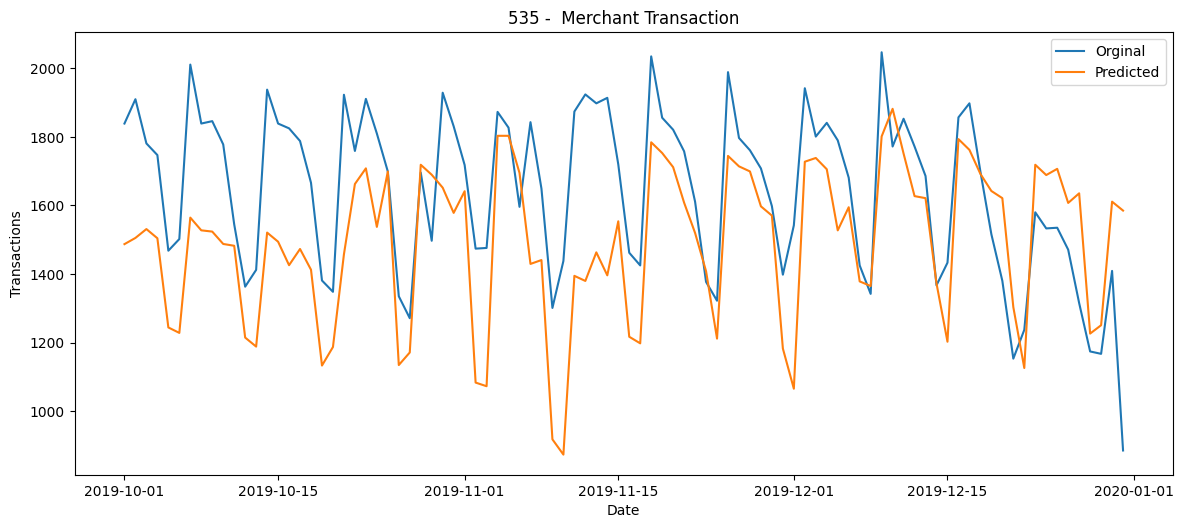

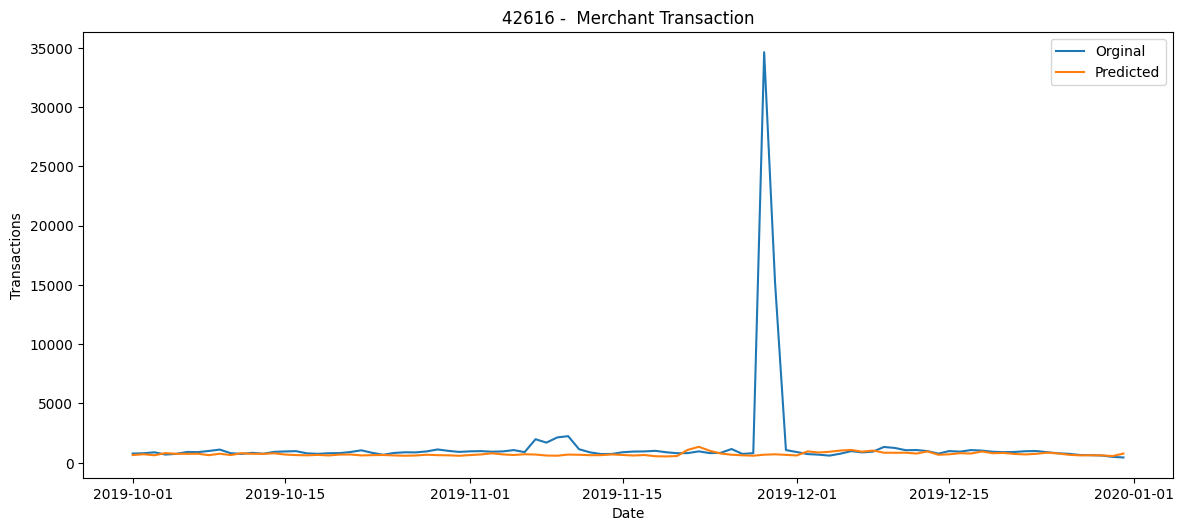

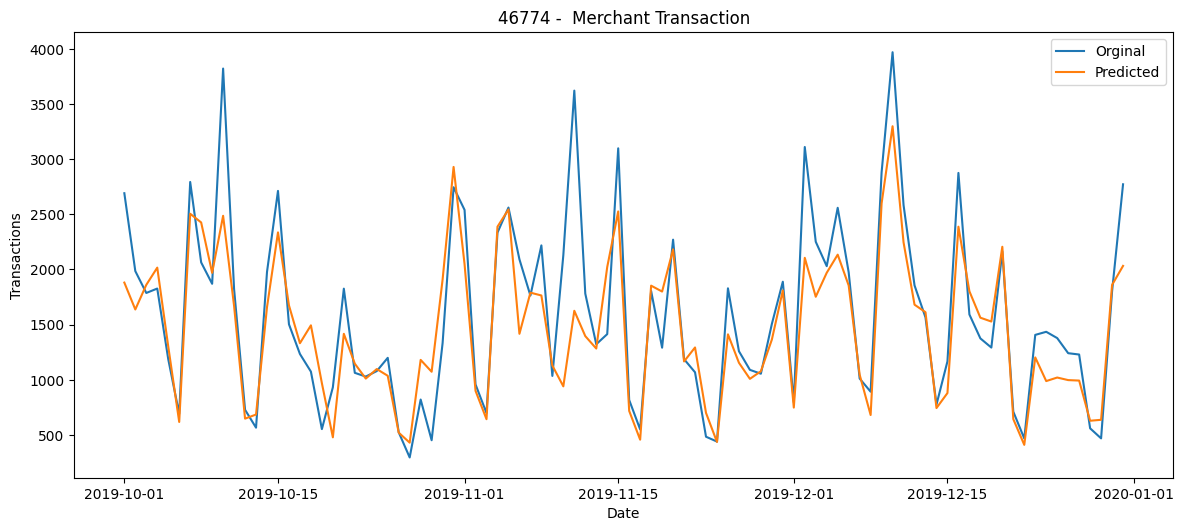

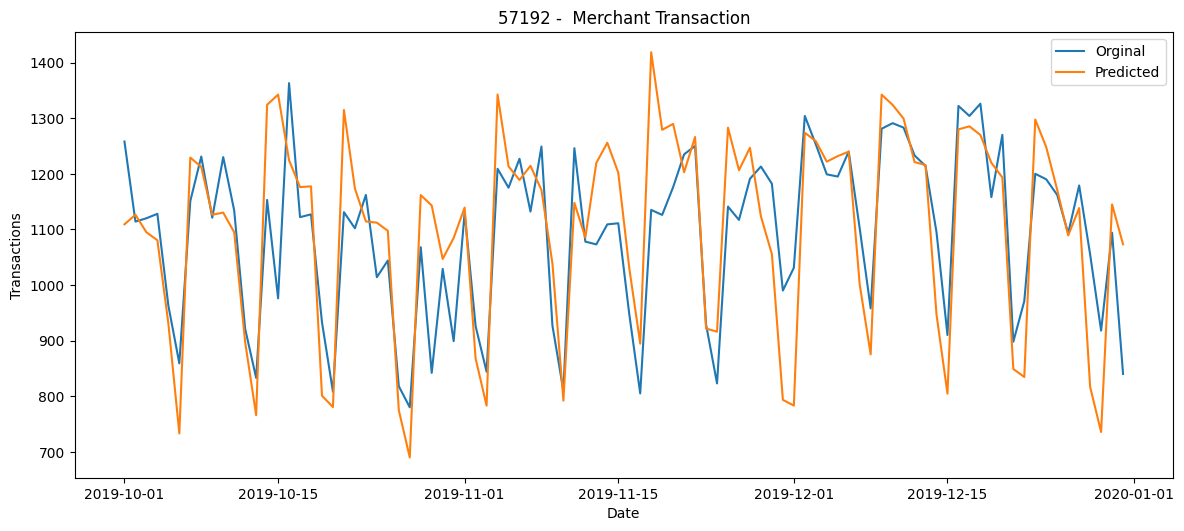

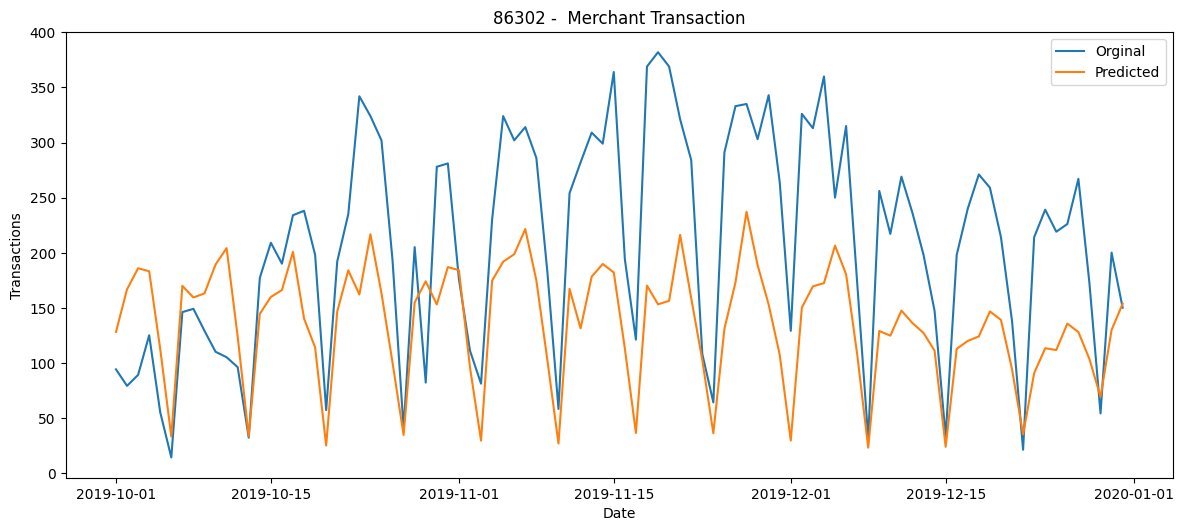

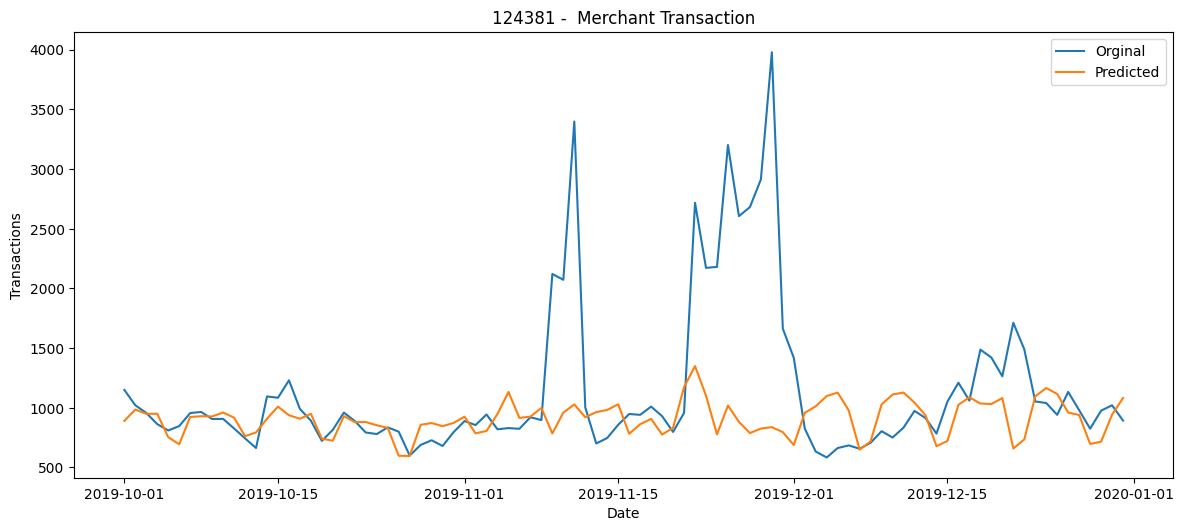

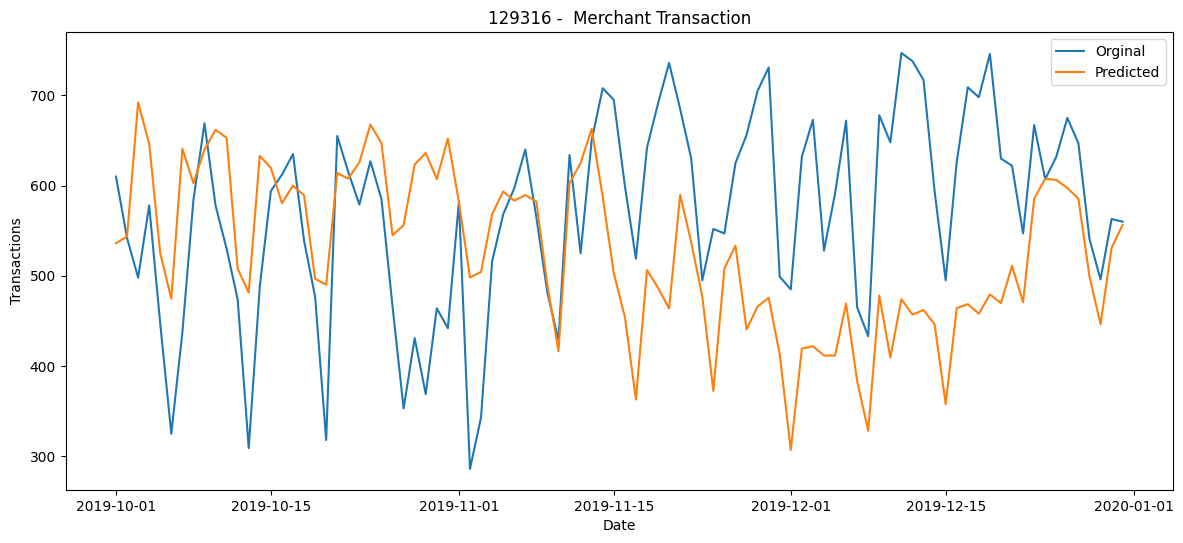

In [113]:
data = pd.read_csv("iyzico_data.csv", parse_dates=["transaction_date"])

train2 = data.loc[(data["transaction_date"]< "2019-10-01"), :]
val2 = data.loc[(data["transaction_date"] >= "2019-10-01") & (data["transaction_date"] < "2020-01-01"), :]
test2 = data.loc[(data["transaction_date"] >= "2020-10-01") & (data["transaction_date"] < "2021-01-01"), :]
val2["val_pred"] = y_pred_val

def plot_pred_orginal(df, pred="val_pred"):
    for i, merchant in enumerate(df["merchant_id"].unique()):
        plt.figure(figsize=(12, 5 * len(df["merchant_id"].unique())))
        plt.subplot(len(df["merchant_id"].unique()), 1, i+1)
        masked_data = df[
            (df["merchant_id"] == merchant)
        ]
        plt.plot(masked_data["transaction_date"], masked_data["Total_Transaction"], label="Orginal")
        plt.plot(masked_data["transaction_date"], masked_data[pred], label="Predicted")
        plt.title(f"{merchant} -  Merchant Transaction")
        plt.xlabel('Date')
        plt.ylabel('Transactions')
        plt.tight_layout()
        plt.legend()
        plt.show()

plot_pred_orginal(val2, "val_pred")

## 8.3. Feature Importance

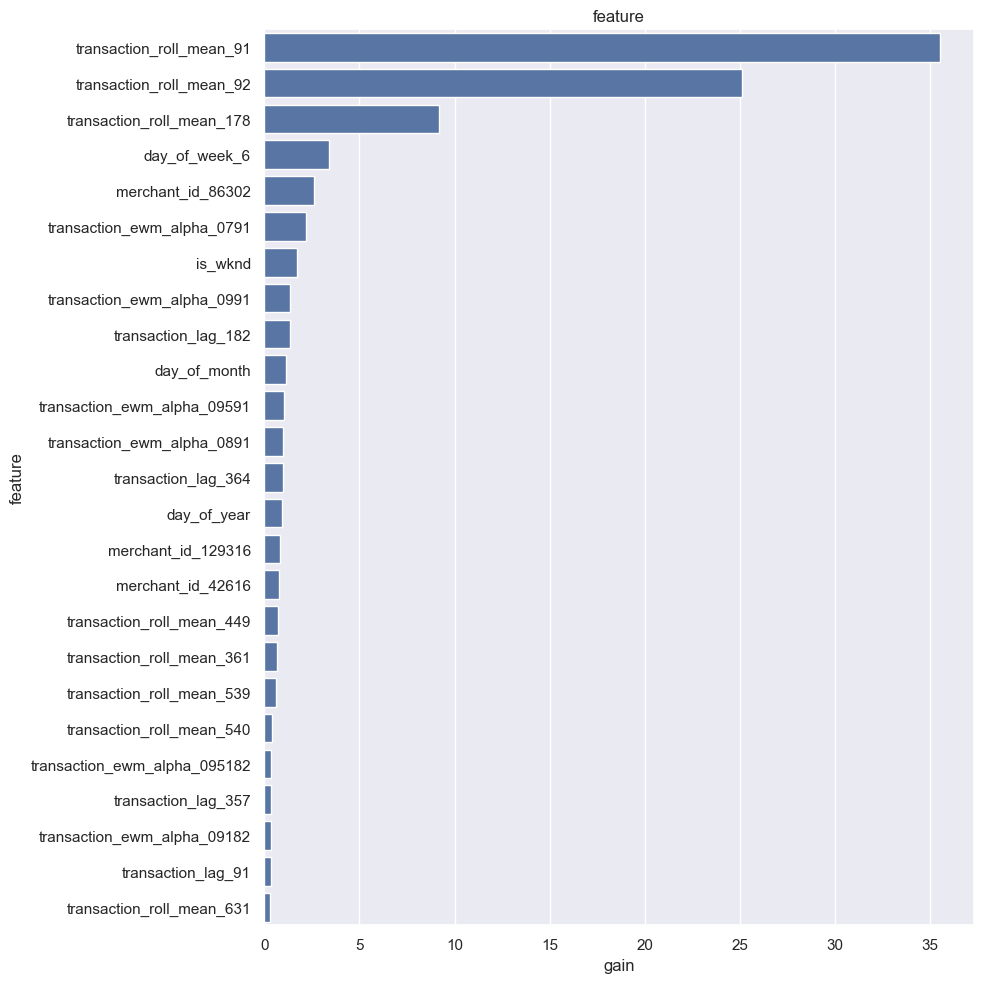

feature  split   gain
64       transaction_roll_mean_91     30 35.526
65       transaction_roll_mean_92     28 25.097
66      transaction_roll_mean_178     15  9.178
201                 day_of_week_6     12  3.413
192             merchant_id_86302      8  2.603
144    transaction_ewm_alpha_0791      4  2.184
3                         is_wknd     22  1.744
104    transaction_ewm_alpha_0991      4  1.334
25            transaction_lag_182      5  1.332
0                    day_of_month     40  1.140
84    transaction_ewm_alpha_09591      4  1.035
124    transaction_ewm_alpha_0891      1  1.008
47            transaction_lag_364     19  0.983
1                     day_of_year     31  0.907
194            merchant_id_129316      7  0.850
189             merchant_id_42616     11  0.759
74      transaction_roll_mean_449      7  0.718
73      transaction_roll_mean_361      6  0.682
77      transaction_roll_mean_539      6  0.594
78      transaction_roll_mean_540      4  0.432
90   transaction_ewm_alpha_095182      3  0.368
40            transaction_lag_357      8  0.354
110   transaction_ewm_alpha_09182      3  0.345
11             transaction_lag_91      7  0.336
82      transaction_roll_mean_631      2  0.291
2                    week_of_year     13  0.288
150   transaction_ewm_alpha_07182      1  0.283
48            transaction_lag_365     12  0.265
37            transaction_lag_354     14  0.259
39            transaction_lag_356      7  0.249
69      transaction_roll_mean_181      5  0.241
13            transaction_lag_170     10  0.237
190             merchant_id_46774     10  0.236
191             merchant_id_57192      6  0.233
54            transaction_lag_538      7  0.212
32            transaction_lag_189      8  0.203
67      transaction_roll_mean_179      4  0.198
75      transaction_roll_mean_450      2  0.161
72      transaction_roll_mean_360      3  0.150
71      transaction_roll_mean_359      3  0.148
68      transaction_roll_mean_180      2  0.131
76      transaction_roll_mean_451      1  0.130
83      transaction_roll_mean_720      3  0.128
70      transaction_roll_mean_182      4  0.127
15            transaction_lag_172      2  0.122
79      transaction_roll_mean_541      3  0.121
164    transaction_ewm_alpha_0591      5  0.121
38            transaction_lag_355      8  0.109
207                       month_6      7  0.107
188               merchant_id_535      7  0.087
46            transaction_lag_363      9  0.077
185            is_summer_solstice      5  0.077
80      transaction_roll_mean_629      3  0.075
7                is_quarter_start      2  0.073
169   transaction_ewm_alpha_05181      1  0.072
173   transaction_ewm_alpha_05361      3  0.071
81      transaction_roll_mean_630      1  0.066
85    transaction_ewm_alpha_09592      3  0.063
209                       month_8      5  0.062
208                       month_7      2  0.060
14            transaction_lag_171      4  0.060
52            transaction_lag_369      6  0.058
35            transaction_lag_351      6  0.055
165    transaction_ewm_alpha_0592      3  0.047
167   transaction_ewm_alpha_05179      2  0.045
16            transaction_lag_173      2  0.044
175   transaction_ewm_alpha_05450      1  0.044
45            transaction_lag_362      5  0.040
170   transaction_ewm_alpha_05182      2  0.039
19            transaction_lag_176      1  0.038
177   transaction_ewm_alpha_05539      1  0.038
51            transaction_lag_368      4  0.037
174   transaction_ewm_alpha_05449      3  0.036
12             transaction_lag_92      2  0.036
168   transaction_ewm_alpha_05180      1  0.036
145    transaction_ewm_alpha_0792      3  0.036
23            transaction_lag_180      4  0.035
33            transaction_lag_190      3  0.035
31            transaction_lag_188      4  0.033
53            transaction_lag_370      2  0.033
210                       month_9      3  0.032
130   transaction_ewm_alpha_08182      1  0.030
186                 is_black_week      4  

In [115]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance("gain")
    feat_imp = pd.DataFrame({"feature": model.feature_name(),
                            "split": model.feature_importance("split"),
                            "gain": 100 * gain / gain.sum()}).sort_values("gain", ascending=False)

    if plot:
        plt.figure(figsize = (10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title("feature")
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, plot=True, num=30)

## 9. Final Model

In [117]:
train = df.loc[(df["transaction_date"]< "2020-10-01"), :]
test = df.loc[(df["transaction_date"] >= "2020-10-01") & (df["transaction_date"] < "2021-01-01"), :]

cols = [col for col in train.columns if col not in ["transaction_date", "Total_Transaction", "Total_Paid", "year"]]

Y_train = train["Total_Transaction"]
X_train = train[cols]

Y_test = val["Total_Transaction"]
X_test = val[cols]

Y_train.shape, X_train.shape, Y_test.shape, X_test.shape

((7023,), (7023, 214), (644,), (644, 214))

In [119]:
# Let's remove the variables with a gain value of 0:

feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

impt_feats = [col for col in cols if col not in importance_zero]

X_train=X_train[impt_feats]
X_test=X_test[impt_feats]

                          feature  split   gain
64       transaction_roll_mean_91     30 35.526
65       transaction_roll_mean_92     28 25.097
66      transaction_roll_mean_178     15  9.178
201                 day_of_week_6     12  3.413
192             merchant_id_86302      8  2.603
144    transaction_ewm_alpha_0791      4  2.184
3                         is_wknd     22  1.744
104    transaction_ewm_alpha_0991      4  1.334
25            transaction_lag_182      5  1.332
0                    day_of_month     40  1.140
84    transaction_ewm_alpha_09591      4  1.035
124    transaction_ewm_alpha_0891      1  1.008
47            transaction_lag_364     19  0.983
1                     day_of_year     31  0.907
194            merchant_id_129316      7  0.850
189             merchant_id_42616     11  0.759
74      transaction_roll_mean_449      7  0.718
73      transaction_roll_mean_361      6  0.682
77      transaction_roll_mean_539      6  0.594
78      transaction_roll_mean_540      4

In [121]:
best_params

{'num_leaves': 14,
 'learning_rate': 0.16692439850821414,
 'feature_fraction': 0.767726437302691,
 'max_depth': 9,
 'metric': {'mae'},
 'objective': 'regression',
 'verbosity': -1,
 'nthread': -1,
 'early_stopping_rounds': 200,
 'num_boost_round': 5000}

In [123]:
lgb_params = {"num_leaves": 14,
             "learning_rate": 0.16692439850821414,
             "feature_fraction": 0.767726437302691,
             "max_depth": 9,
             "verbose": -1,
             "nthread": -1,
             "num_boost_round": best_iteration}

lgbtrain_all = lgb.Dataset(data = X_train, label = Y_train, feature_name=impt_feats)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=lgb_params["num_boost_round"])

test_preds = final_model.predict(X_test, num_iteration=lgb_params["num_boost_round"])

test_preds = np.expm1(test_preds)

test2["test_pred"] = test_preds

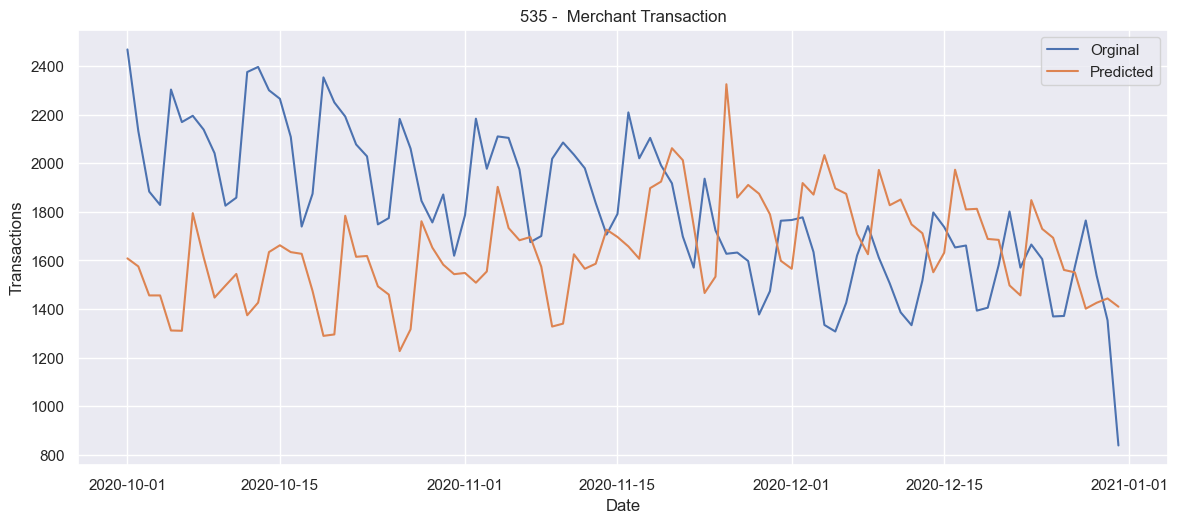

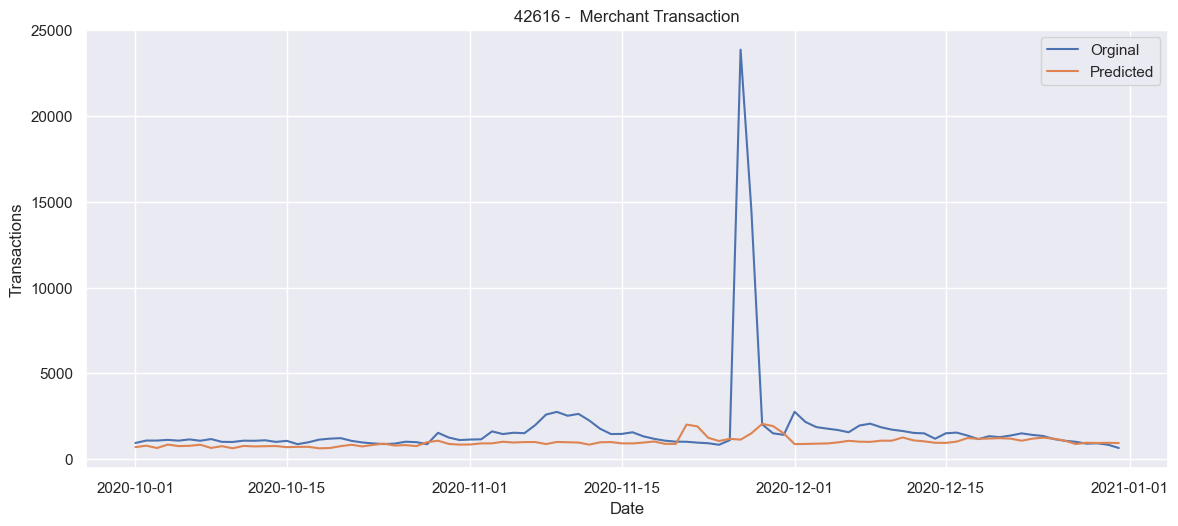

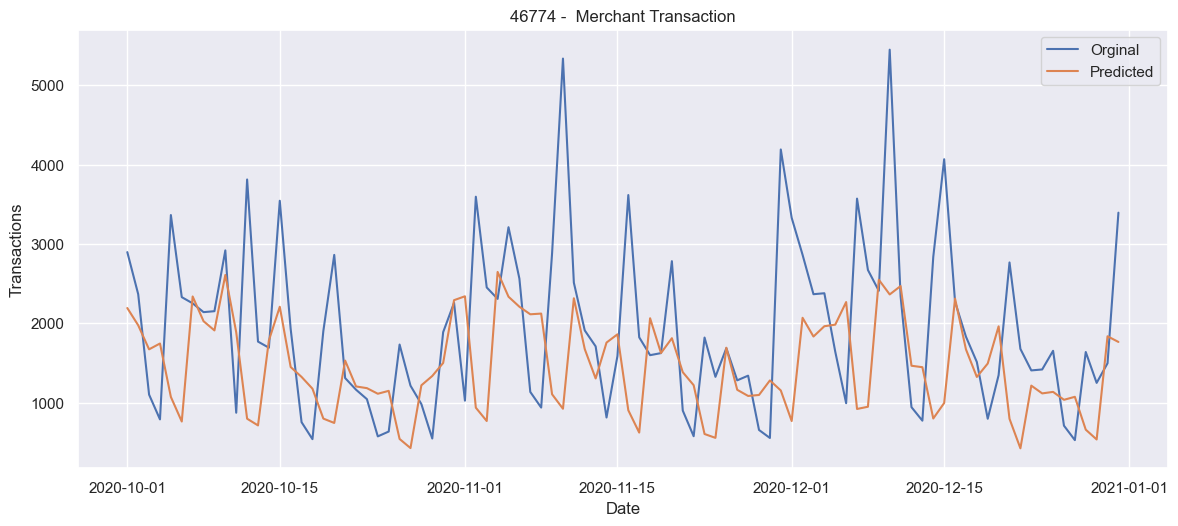

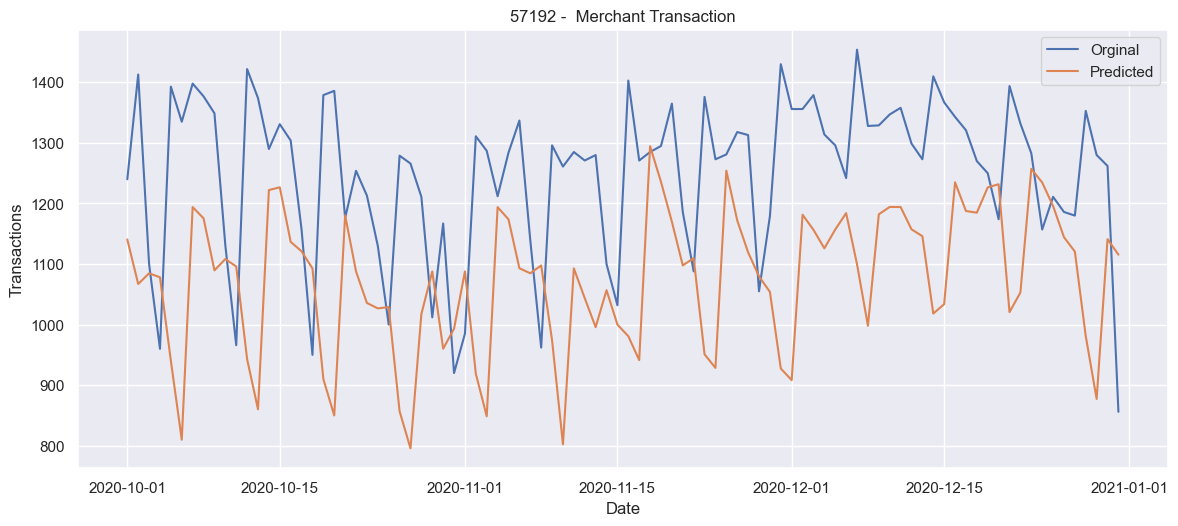

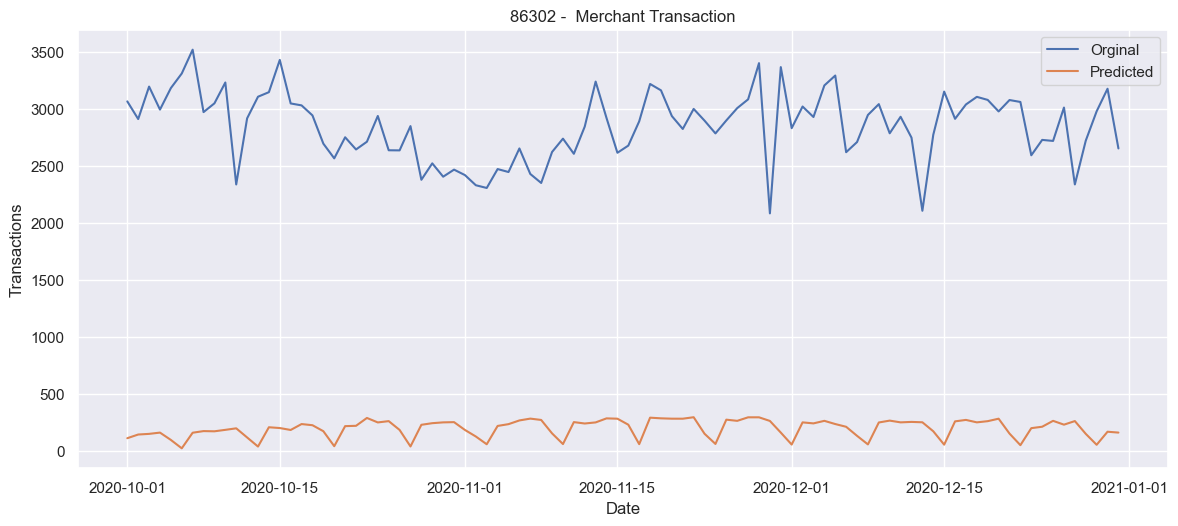

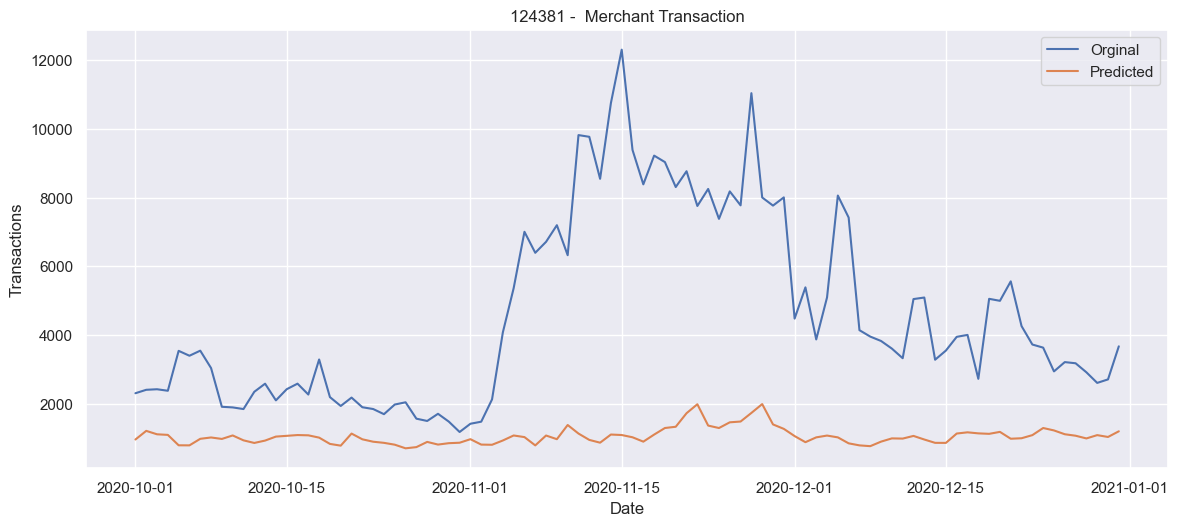

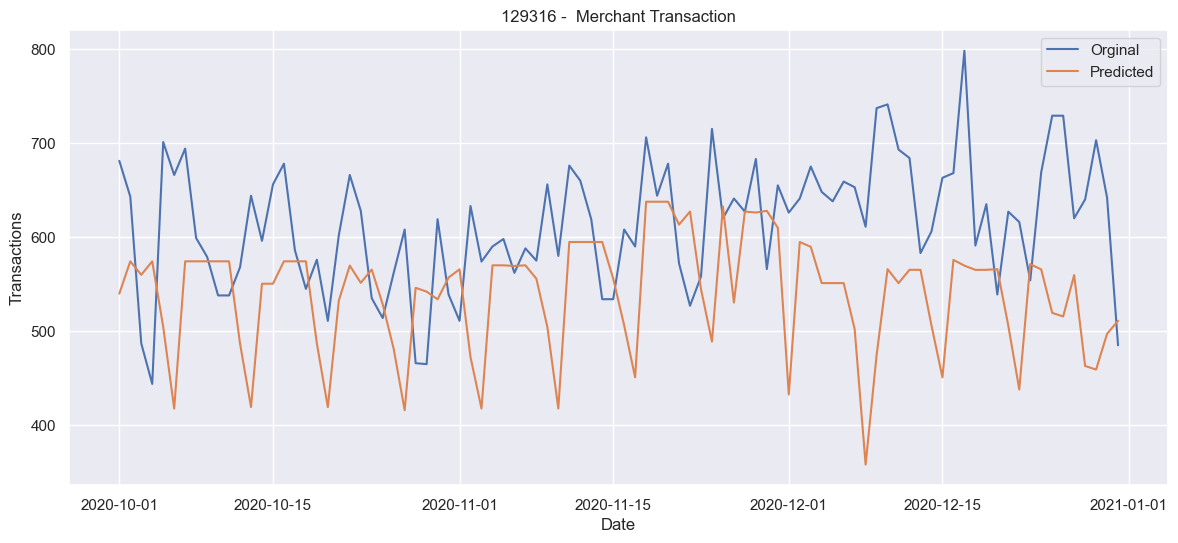

In [125]:
plot_pred_orginal(test2, "test_pred")